In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torch
from scipy.interpolate import make_interp_spline, make_smoothing_spline, UnivariateSpline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
import spikeinterface.qualitymetrics as sqm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter

In [2]:
scratch = f'/home/lss72/palmer_scratch/spike_sort'

def load_res(time):
    data_dir = f'/home/lss72/TempoSort/data/2017_UCL_Neuropixels/{time}s'
    
    # outputs saved to results_dir
    results_dir = Path(data_dir).joinpath('kilosort4')
    
    # load 'em
    ops = np.load(results_dir / 'ops.npy', allow_pickle=True).item()
    camps = pd.read_csv(results_dir / 'cluster_Amplitude.tsv', sep='\t')['Amplitude'].values
    contam_pct = pd.read_csv(results_dir / 'cluster_ContamPct.tsv', sep='\t')['ContamPct'].values
    chan_map =  np.load(results_dir / 'channel_map.npy')
    templates =  np.load(results_dir / 'templates.npy')
    chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
    chan_best = chan_map[chan_best]
    amplitudes = np.load(results_dir / 'amplitudes.npy')
    st = np.load(results_dir / 'spike_times.npy')
    clu = np.load(results_dir / 'spike_clusters.npy')
    firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
    dshift = ops['dshift']
    
    return ops, camps, contam_pct, chan_map, templates, chan_best, amplitudes, st, clu, firing_rates, dshift

ops, camps, contam_pct, chan_map, templates, chan_best, amplitudes, st, clu, firing_rates, dshift = load_res(60)

In [3]:
# import data
inputfilename = f'{scratch}/neuropixels.bin'
nrows = 385 # num channels
with open(inputfilename, 'rb') as fid:
    data_array = np.fromfile(fid, np.int16).reshape((-1, nrows)).T
data_array.shape

(385, 113208768)

In [4]:
# Get high-pass filtering procedures from Kilosort 4
#https://github.com/MouseLand/Kilosort/blob/main/kilosort/preprocessing.py

from scipy.signal import butter, filtfilt
def get_highpass_filter(fs=30000, cutoff=300, device=torch.device('cuda')):
    """Filter to use for high-pass filtering."""
    NT = 30122
    
    # a butterworth filter is specified in scipy
    b,a = butter(3, cutoff, fs=fs, btype='high')

    # a signal with a single entry is used to compute the impulse response
    x = np.zeros(NT)
    x[NT//2] = 1

    # symmetric filter from scipy
    hp_filter = filtfilt(b, a , x).copy()
    
    hp_filter = torch.from_numpy(hp_filter).to(device).float()
    return hp_filter

def fft_highpass(hp_filter, NT=30122, device=torch.device('cuda')):
    """Convert filter to fourier domain."""
#     device = hp_filter.device
    ft = hp_filter.shape[0]

    # the filter is padded or cropped depending on the size of NT
    if ft < NT:
        pad = (NT - ft) // 2
        fhp = fft(torch.cat((torch.zeros(pad).to(device), 
                             hp_filter,
                             torch.zeros(pad + (NT-pad*2-ft)).to(device))))
    elif ft > NT:
        crop = (ft - NT) // 2 
        fhp = fft(hp_filter[crop : crop + NT])
    else:
        fhp = fft(hp_filter)
    return fhp

from torch.fft import fft, ifft, fftshift
sample_rate = 30000


# filter raw data -- do it one channel at a time due to memory constraints
data_array_unfilt = data_array
hp_filter = get_highpass_filter(sample_rate)
for i in tqdm(range(len(chan_map))):
    chan = chan_map[i]
    
    X = torch.from_numpy(data_array[chan:chan+1]).to(torch.device('cuda'))

    # apply filter in Fourier space
    fwav = fft_highpass(hp_filter, NT=X.shape[1])
    X = torch.real(ifft(fft(X) * torch.conj(fwav)))
    X = fftshift(X, dim = -1)
    
    data_array[chan] = X[0].cpu() #grab the single row from X corresponding to chan

100%|██████████| 374/374 [21:42<00:00,  3.48s/it]


In [5]:
# getting spike windows
def get_spike_windows_per_template(templi, data_array=data_array):
    which_spikes_from_templ = np.flatnonzero(clu == templi)
    half_window = templates.shape[1]//2
    which_chans = [chan_best[templi]]
    
    # crop out a window around the spike times for each channel in this template
    # use `st[spki]` to get the actual time (sample #) of each spike
    all_spk_windows = []
    actual_spike_ts = st[which_spikes_from_templ]
    for spki in which_spikes_from_templ:
        t0, t1 = max(0, st[spki]-half_window), min(st[spki]+half_window+1, data_array.shape[1])
        
        if t1 - t0 < 2*half_window+1:
            start, end = 0, 2*half_window+1
            window = np.nan*np.ones((len(which_chans),2*half_window+1))
            if st[spki] < half_window:
                start = half_window-st[spki]
            if st[spki] + half_window + 1 > data_array.shape[1]:
                end -= ( data_array.shape[1] - st[spki] + half_window + 1 )
        
            window[:,start:end] = data_array[which_chans,t0:t1]
        else:
            window = data_array[which_chans,t0:t1]
        all_spk_windows.append(window)

    return all_spk_windows

def get_long_spike_windows_per_template(templi):
    which_spikes_from_templ = np.flatnonzero(clu == templi)
    half_window = int(templates.shape[1]*3/4)
    which_chans = [chan_best[templi]]
    
    # crop out a window around the spike times for each channel in this template
    # use `st[spki]` to get the actual time (sample #) of each spike
    all_spk_windows = []
    actual_spike_ts = st[which_spikes_from_templ]
    for spki in which_spikes_from_templ:
        t0, t1 = max(0, st[spki]-half_window), min(st[spki]+half_window+1, data_array.shape[1])
        
        if t1 - t0 < 2*half_window+1:
            start, end = 0, 2*half_window+1
            window = 0*np.ones((len(which_chans),2*half_window+1))
            if st[spki] < half_window:
                start = half_window-st[spki]
            if st[spki] + half_window + 1 > data_array.shape[1]:
                end -= ( data_array.shape[1] - st[spki] + half_window + 1 )
        
            window[:,start:end] = data_array[which_chans,t0:t1]
        else:
            window = data_array[which_chans,t0:t1]
        all_spk_windows.append(window)

    return all_spk_windows



In [24]:
# calculating correlation of all main channel data

xcorrs = []

for t_num in tqdm(range(len(templates))):

    # grabbing + normalizing template (main channel only)
    main_channel = chan_best[t_num]

    if main_channel >= 374: continue
    
    templ = templates[t_num,:,main_channel]
    norm_templ = templ / np.linalg.norm(templ)

    xcorrs_per_templ = []

    # get all spike templates
    spk_wind = get_spike_windows_per_template(t_num)
    for s in spk_wind:

        # ignoring spikes with nan
        if np.isfinite(s[0]).all():
            
            # make interpolation spline
            spl = make_interp_spline(range(len(s[0])), s[0])
            data_interp = spl(range(len(s[0]))).T
            norm_int = data_interp / np.linalg.norm(data_interp)
            
            # finding xcorr (max of full correlation to account for time offset)
            corr = np.correlate(norm_templ, norm_int, 'full')
            xcorrs_per_templ.append(max(corr))

    xcorrs.append(np.mean(xcorrs_per_templ))


 12%|█▏        | 45/388 [00:10<01:21,  4.20it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'Frequency')

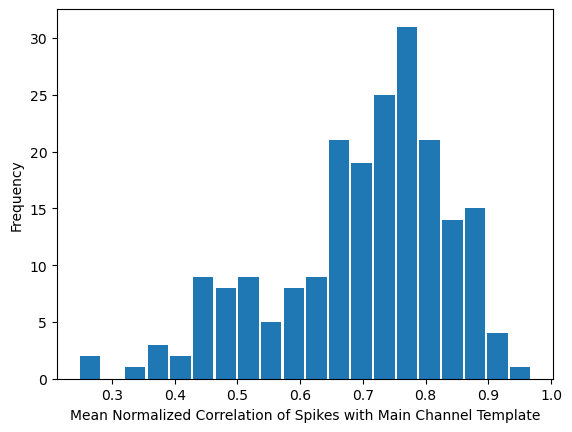

In [7]:
fig, ax = plt.subplots()
ax.hist(xcorrs, bins = 20, rwidth=0.9)
ax.set_xlabel("Mean Normalized Correlation of Spikes with Main Channel Template")
ax.set_ylabel("Frequency")

Text(0.5, 0, 'Mean Normalized Corr. of Smoothed Spikes with Main Channel Template')

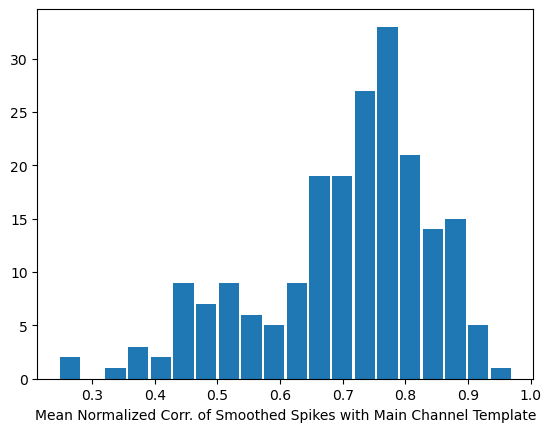

In [20]:
fig, ax = plt.subplots()
ax.hist(xcorrs, bins = 20, rwidth=0.9)
ax.set_xlabel("Mean Normalized Corr. of Smoothed Spikes with Main Channel Template")
ax.set_ylabel("Frequency")

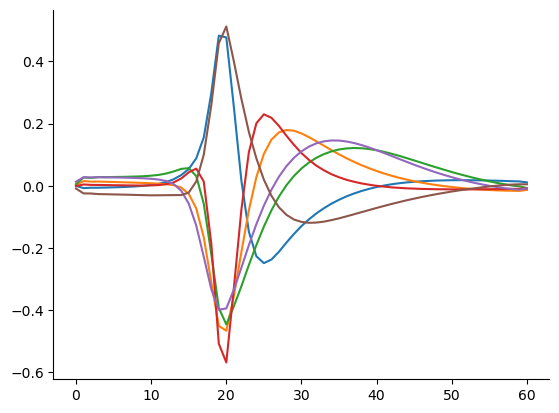

In [43]:
# load original templates
dd = np.load('wTEMP.npz')
wTEMP = dd['wTEMP']
# visualize each waveform
for w in wTEMP:
    plt.plot(w)
plt.show()

In [56]:
# ccomputing same thing but for the naive templates
xcorrs_per_templ = [[], [], [], [], [], []]
spk_wind = []

for t_num in tqdm(range(len(templates))):

    # grabbing + normalizing template (main channel only)
    main_channel = chan_best[t_num]

    if main_channel >= 374: continue

    # get all spike templates
    spk_wind += get_spike_windows_per_template(t_num)

for s in tqdm(spk_wind):

    # ignoring spikes with nan
    if np.isfinite(s[0]).all():

        # make interpolation spline
        spl = make_interp_spline(range(len(s[0])), s[0])
        data_interp = spl(range(len(s[0]))).T
        norm_int = data_interp / np.linalg.norm(data_interp)

        max_corr = 0

        for i, d in enumerate(wTEMP):
            norm_templ = d / np.linalg.norm(d)
        
            # finding xcorr (max of full correlation to account for time offset)
            corr = np.correlate(norm_templ, norm_int, 'full')
            if max(corr) > max_corr:
                saved_i = i
                max_corr = max(corr)
                
        xcorrs_per_templ[saved_i].append(max_corr)

xcorrs = [np.mean(x) for x in xcorrs_per_templ]


100%|██████████| 312103/312103 [01:37<00:00, 3209.55it/s]


Text(0, 0.5, 'Frequency')

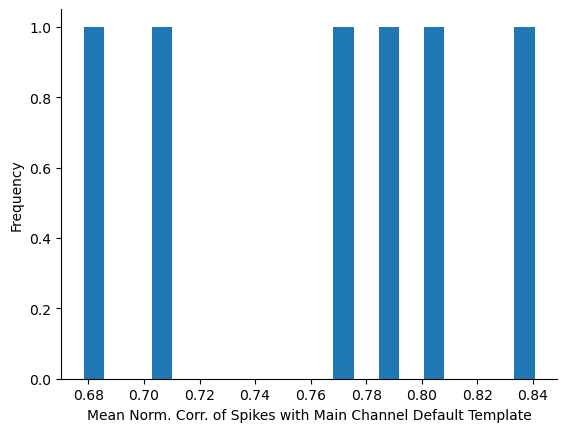

In [57]:
fig, ax = plt.subplots()
ax.hist(xcorrs, bins = 20, rwidth=0.9)
ax.set_xlabel("Mean Norm. Corr. of Spikes with Main Channel Default Template")
ax.set_ylabel("Frequency")

In [8]:
# adapted from ecephys_spike_sorting github

def isi_violations(spike_train, min_time, max_time, isi_threshold, min_isi=0):
    """Calculate ISI violations for a spike train.

    Based on metric described in Hill et al. (2011) J Neurosci 31: 8699-8705

    modified by Dan Denman from cortex-lab/sortingQuality GitHub by Nick Steinmetz

    Inputs:
    -------
    spike_train : array of spike times
    min_time : minimum time for potential spikes
    max_time : maximum time for potential spikes
    isi_threshold : threshold for isi violation
    min_isi : threshold for duplicate spikes

    Outputs:
    --------
    fpRate : rate of contaminating spikes as a fraction of overall rate
        A perfect unit has a fpRate = 0
        A unit with some contamination has a fpRate < 0.5
        A unit with lots of contamination has a fpRate > 1.0
    num_violations : total number of violations

    """

    duplicate_spikes = np.where(np.diff(spike_train) <= min_isi)[0]

    spike_train = np.delete(spike_train, duplicate_spikes + 1)
    isis = np.diff(spike_train)

    num_spikes = len(spike_train)
    num_violations = sum(isis < isi_threshold)
    time_arr = isis[isis < isi_threshold]
    violation_time = 2*num_spikes*(isi_threshold - min_isi)
    total_rate = _firing_rate(spike_train, min_time, max_time)
    violation_rate = num_violations/violation_time
    fpRate = violation_rate/total_rate

    return fpRate, num_violations, time_arr
    
def calculate_isi_violations(spike_times, spike_clusters, total_units, isi_threshold, min_isi):

    cluster_ids = np.unique(spike_clusters)

    viol_rates = np.zeros((total_units,))
    num = np.zeros((total_units,))
    viol_times = []

    for idx, cluster_id in tqdm(enumerate(cluster_ids)):

        for_this_cluster = (spike_clusters == cluster_id)
        # print(spike_times[for_this_cluster])
        viol_rates[idx], num[idx], viols = isi_violations(spike_times[for_this_cluster],
                                                       min_time = np.min(spike_times),
                                                       max_time = np.max(spike_times),
                                                       isi_threshold=isi_threshold,
                                                       min_isi = min_isi)
        viol_times.append(viols)

    return viol_rates, num, viol_times


def _firing_rate(spike_train, min_time = None, max_time = None):
    """Calculate firing rate for a spike train.

    If no temporal bounds are specified, the first and last spike time are used.

    Inputs:
    -------
    spike_train : numpy.ndarray
        Array of spike times in seconds
    min_time : float
        Time of first possible spike (optional)
    max_time : float
        Time of last possible spike (optional)

    Outputs:
    --------
    fr : float
        Firing rate in Hz

    """

    if min_time is not None and max_time is not None:
        duration = max_time - min_time
    else:
        duration = np.max(spike_train) - np.min(spike_train)

    fr = spike_train.size / duration

    return fr

In [6]:
NUM_SAMP_PER_SEC = 30000
def calc_isi_viol_ratio(st, clu):
    params = dict()
    params['isi_threshold'] = 0.0005 * NUM_SAMP_PER_SEC # s * num samp / s
    params['min_isi'] = 0
    total_units = len(np.unique(clu))
    isi_viol_rate, num_violations, viol_times = calculate_isi_violations(st, clu, total_units, params['isi_threshold'], params['min_isi'])
    return isi_viol_rate, (np.sum(num_violations) / len(clu)), [x/NUM_SAMP_PER_SEC for xs in viol_times for x in xs]


In [41]:
# calculating number and ratio of isi violations

# array of the tmax parameters
# sec_arr = [5, 10, 15, 30, 45, 60, 300, 600]
sec_arr = [5, 10, 15, 30, 45, 60]

ratio_arr = np.zeros(len(sec_arr))
corr_arr = np.zeros((len(sec_arr), len(np.unique(clu)),))
corr_arr = []
viol_times = []

# loading results for each tmax and calculating isi metrics
for i, s in enumerate(sec_arr):
    ops, camps, contam_pct, chan_map, templates, chan_best, amplitudes, st, clu, firing_rates, dshift = load_res(s)
    isi_viol_rate, ratio_arr[i], viols = calc_isi_viol_ratio(st, clu)
    # norm_contam_pct = contam_pct / np.linalg.norm(contam_pct)
    corr_arr.append(pearsonr(isi_viol_rate, contam_pct).statistic)
    viol_times.append(viols)

print(ratio_arr)
print(corr_arr)
print("min of flattened array:", np.min([x for xs in viol_times for x in xs]))

86it [00:00, 11484.29it/s]
103it [00:00, 8325.08it/s]
137it [00:00, 6784.42it/s]
278it [00:00, 3413.72it/s]
345it [00:00, 2371.09it/s]
388it [00:00, 1894.16it/s]

[0.02293033 0.01866523 0.01295843 0.00790742 0.00531947 0.00433376]
[0.5374333488078072, 0.4138738408131508, 0.5297659423219412, 0.4423079823007599, 0.4179213833575702, 0.49622522356175175]
min of flattened array: 0.00023333333333333333


Text(0.5, 1.0, 'Histogram of ISI Violation Times Per Second')

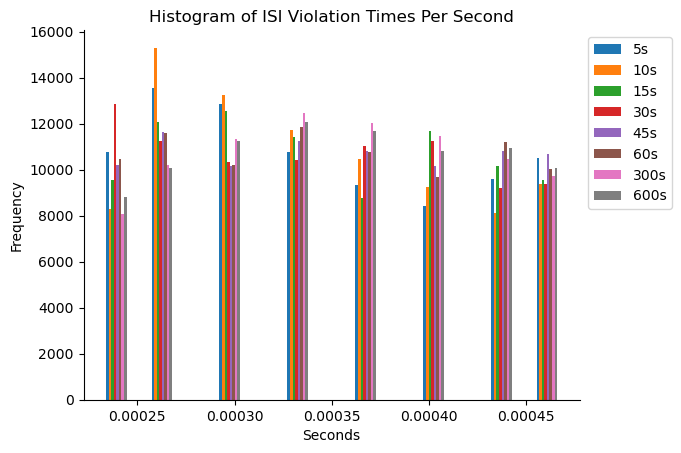

In [30]:
# plotting histogram of isi violation counts
fig, ax = plt.subplots()
label_arr = [str(x)+'s' for x in sec_arr]
ax.hist(viol_times, bins = 20, rwidth=0.9, label=label_arr, density=True)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
ax.set_xlabel("Seconds")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of ISI Violation Times Per Second")

Text(0.5, 1.0, 'ISI violation fraction and correlation wih contamination')

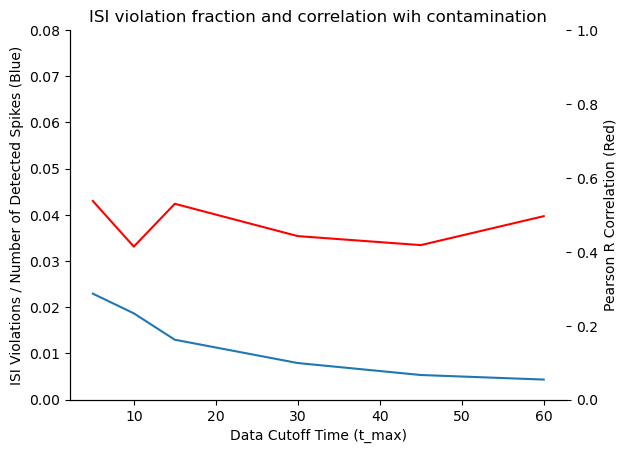

In [42]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(sec_arr, ratio_arr)
ax2.plot(sec_arr, corr_arr, color='r')
ax.set_ylim(0, 0.08)
ax2.set_ylim(0, 1)
ax.set_xlabel("Data Cutoff Time (t_max)")
ax.set_ylabel("ISI Violations / Number of Detected Spikes (Blue)")
ax2.set_ylabel("Pearson R Correlation (Red)")
ax.set_title("ISI violation fraction and correlation wih contamination")

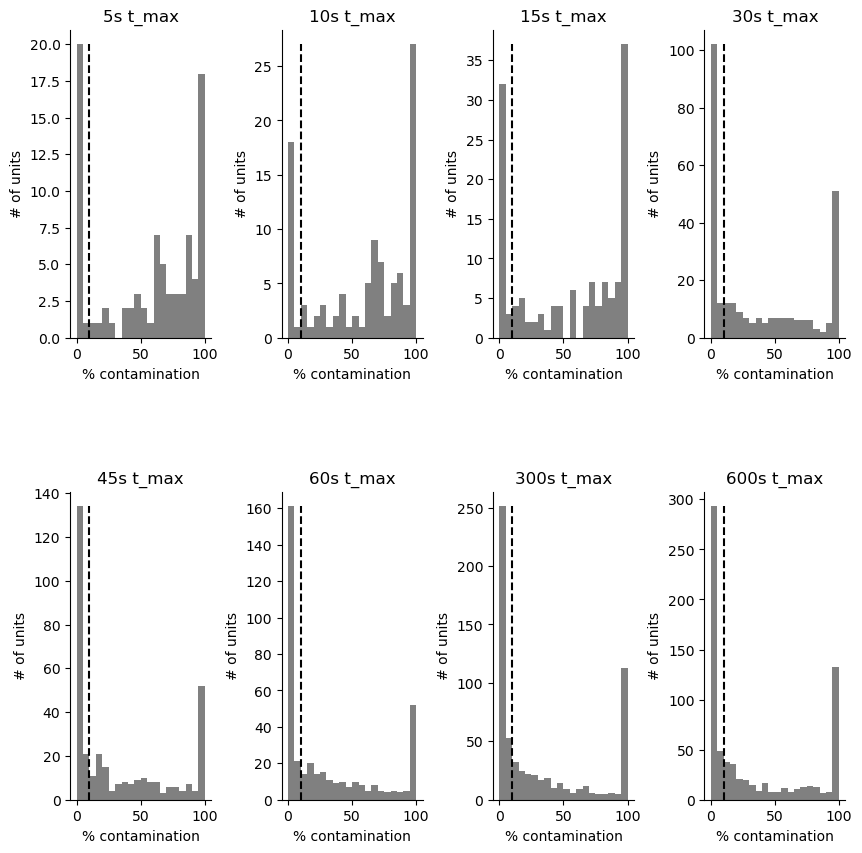

In [15]:
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(10,10), dpi=100)
grid = gridspec.GridSpec(2, 4, figure=fig, hspace=0.5, wspace=0.5)

for i in range(2*4):
    ops, camps, contam_pct, chan_map, templates, chan_best, amplitudes, st, clu, firing_rates, dshift = load_res(sec_arr[i])
    ax = fig.add_subplot(grid[i // 4, i % 4])
    nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
    ax.plot([10, 10], [0, nb[0].max()], 'k--')
    ax.set_xlabel('% contamination')
    ax.set_ylabel('# of units')
    ax.set_title(f'{sec_arr[i]}s t_max')

In [8]:
# gtting all original templates?
templi = 0
og_templates = []

for i in range(374): #plot the waveform from each channel participating in that template
    if abs(templates[templi,:,i]).sum() > 0:
        og_templates.append(templates[templi,:,i])

In [7]:
SAMP_RATE = 30 # samples per ms
half_ms_len = int(round(.5 * SAMP_RATE))
slope_delta = int(round(SAMP_RATE/10.))

X = []#np.zeros((all_waveforms.shape[0],3))
curr = []
X_is = []    
var_compare = []
lens = []

pos_spiking = []
triphasic = []
compound = []

pca = PCA(n_components=4)

for t_num in tqdm(range(len(templates))):

    # getting longer spike window
    waves = get_long_spike_windows_per_template(t_num)

    waves = np.squeeze(waves)

    var_naive = np.sqrt(np.mean(np.var(waves, axis=0)))

    pcs = pca.fit_transform(waves)

    var_pca = np.sqrt(np.mean(np.var(pcs, axis=0)))

    lens.append(np.array((clu == t_num).sum()))

    curr = []

    for wave in waves:

        # ignoring spikes with nan
        if np.isfinite(wave).all():

            # changing this to get 
            # old
            # dp_val, dp_t = np.min(wave), np.argmin(wave[])
            dp_val, dp_t = np.min(wave[2:-slope_delta - half_ms_len]), np.argmin(wave[2:-slope_delta - half_ms_len]) + 2
            ahp_val, ahp_t = np.max(wave[dp_t+1:]),np.argmax(wave[dp_t+1:]) #peak after trough
        
            #NEW: additional types, based on
            #following https://physoc.onlinelibrary.wiley.com/doi/epdf/10.1113/JP280844
            # peak before trough?
            bhp_val = np.max(wave[:dp_t])
                
            params = np.empty(4) # 4 columns for: after-hyper:depolar ratio, 
                                    # trough to after-hyper time, slope 0.5 ms after trough
        
            params[0] = ahp_val/dp_val;
            params[1] = ahp_t/SAMP_RATE;
            params[3] = bhp_val/-dp_val
        
            slope_t = dp_t+half_ms_len
            interval = slope_t - slope_delta, slope_t + slope_delta

            # #slope at (dp_t + half_ms_len) == dp_t + 0.5 ms
            params[2] = (wave[interval[1]] - wave[interval[0]])/((interval[1] - interval[0])/SAMP_RATE)
        
            X.append(params)
            curr.append(params)
            X_is.append(t_num)

    four_d_var = np.sqrt(np.mean(np.var(curr, axis=0)))

    var_compare.append((var_naive, four_d_var, var_pca))

    print(f'cluster {t_num}: 4d = {four_d_var}, naive = {var_naive}')
        
X = np.array(X)

  2%|▏         | 7/388 [00:00<00:14, 27.19it/s]

cluster 0: 4d = 60.46391360213581, naive = 15.591610315989707
cluster 1: 4d = 59.5600632325283, naive = 18.55584369230797
cluster 2: 4d = 46.197624394502675, naive = 12.565247994357849
cluster 3: 4d = 51.75743001998453, naive = 15.00239760716453
cluster 4: 4d = 75.36393491946652, naive = 21.22473220081198
cluster 5: 4d = 69.41814997327698, naive = 16.76605705417588
cluster 6: 4d = 55.83858015803412, naive = 14.255284929917915
cluster 7: 4d = 56.27641028773263, naive = 14.628273129262531
cluster 8: 4d = 49.38728311291604, naive = 12.811310351201444
cluster 9: 4d = 71.7168454538397, naive = 18.09467740149467


  4%|▍         | 16/388 [00:00<00:16, 22.97it/s]

cluster 10: 4d = 72.6748869885795, naive = 20.373191658143263
cluster 11: 4d = 44.372772863826945, naive = 12.603139470288808
cluster 12: 4d = 47.35454010741687, naive = 11.997460755966
cluster 13: 4d = 47.40637222426349, naive = 12.86720802906431
cluster 14: 4d = 46.34441166685179, naive = 12.753842896362361
cluster 15: 4d = 49.25886144995188, naive = 12.810097973382264
cluster 16: 4d = 46.98908440767539, naive = 12.026415018368132
cluster 17: 4d = 57.36381176580637, naive = 13.816931999044126
cluster 18: 4d = 49.629455795061084, naive = 11.810290438805549


  6%|▌         | 22/388 [00:00<00:16, 21.90it/s]

cluster 19: 4d = 55.160335607136595, naive = 12.88293138217717
cluster 20: 4d = 56.04574574686384, naive = 14.488311034675359
cluster 21: 4d = 65.734773843711, naive = 15.33992377008264
cluster 22: 4d = 46.36435584105269, naive = 11.535504328772907
cluster 23: 4d = 63.31653836739243, naive = 15.346213669558606
cluster 24: 4d = 45.27980259956599, naive = 11.704227260401147


  9%|▉         | 34/388 [00:01<00:12, 27.89it/s]

cluster 25: 4d = 54.660291784776845, naive = 14.459284140932523
cluster 26: 4d = 48.84922176948356, naive = 12.505398050499672
cluster 27: 4d = 56.47666283437209, naive = 14.430953344005339
cluster 28: 4d = 51.77513015527856, naive = 13.318512212048173
cluster 29: 4d = 38.7588972745963, naive = 9.251592157680758
cluster 30: 4d = 43.22600335627276, naive = 14.736295594967974
cluster 31: 4d = 34.98624515893497, naive = 9.386036589213933
cluster 32: 4d = 55.631629849996, naive = 13.465695559296456
cluster 33: 4d = 31.959595939386016, naive = 8.542563790483829


 11%|█         | 42/388 [00:01<00:10, 32.11it/s]

cluster 34: 4d = 31.63680569047582, naive = 8.920285456039675
cluster 35: 4d = 43.1439520986889, naive = 11.935638834286575
cluster 36: 4d = 39.51220165002501, naive = 9.77388730353058
cluster 37: 4d = 40.962935133271365, naive = 10.946523179949784
cluster 38: 4d = 38.6994171394394, naive = 10.338414521300411
cluster 39: 4d = 36.43793026656389, naive = 9.11672910695089
cluster 40: 4d = 38.89962445560812, naive = 10.080442987995806
cluster 41: 4d = 28.43766934922211, naive = 7.6400379705875645
cluster 42: 4d = 36.275697934215486, naive = 9.499581982706074


 12%|█▏        | 46/388 [00:01<00:11, 30.92it/s]

cluster 43: 4d = 37.58867226419715, naive = 9.88709339475982
cluster 44: 4d = 28.296154909185404, naive = 7.324342071863574
cluster 45: 4d = 33.54398867030218, naive = 8.841994918528428
cluster 46: 4d = 31.894164886895986, naive = 7.977550373084207
cluster 47: 4d = 32.69414752432179, naive = 8.8042879918103
cluster 48: 4d = 34.269993469710435, naive = 8.70067070704082
cluster 49: 4d = 31.212450778543833, naive = 8.065053057921247


 15%|█▌        | 59/388 [00:02<00:09, 34.87it/s]

cluster 50: 4d = 30.958497965831565, naive = 8.465945651161462
cluster 51: 4d = 30.16414164091174, naive = 7.654413796518365
cluster 52: 4d = 35.46078649610878, naive = 8.837698156938355
cluster 53: 4d = 30.22705580646029, naive = 8.140761339640314
cluster 54: 4d = 33.93540994959844, naive = 9.103106844907067
cluster 55: 4d = 34.64410750953834, naive = 9.038762557336897
cluster 56: 4d = 30.24960167308418, naive = 8.397489328133368
cluster 57: 4d = 31.115172134430484, naive = 8.525744399550474
cluster 58: 4d = 38.87649639846072, naive = 10.384156082862003


 18%|█▊        | 68/388 [00:02<00:09, 35.43it/s]

cluster 59: 4d = 32.68853269974743, naive = 8.367453949995145
cluster 60: 4d = 33.64173303448171, naive = 8.951238472622707
cluster 61: 4d = 34.36197557322393, naive = 9.55011333036117
cluster 62: 4d = 35.56373171949963, naive = 8.51429655122093
cluster 63: 4d = 31.620636984158743, naive = 8.05354211528684
cluster 64: 4d = 45.924647951576254, naive = 10.387441432613931
cluster 65: 4d = 24.091555138064646, naive = 6.6447275167920985
cluster 66: 4d = 38.90397520324631, naive = 10.098025868089882
cluster 67: 4d = 41.98356592245675, naive = 11.24179575267884
cluster 68: 4d = 29.841221987197414, naive = 7.9130109362184164
cluster 69: 4d = 24.055832838340645, naive = 6.167307248487721
cluster 70: 4d = 25.25539184582258, naive = 6.607037217505576


 22%|██▏       | 84/388 [00:02<00:07, 40.23it/s]

cluster 71: 4d = 22.137928886728133, naive = 5.900730159314414
cluster 72: 4d = 23.086510952731146, naive = 5.924424311918493
cluster 73: 4d = 25.900414383011537, naive = 8.083798142807563
cluster 74: 4d = 21.609702303407076, naive = 6.210963987414572
cluster 75: 4d = 22.597853708397587, naive = 5.952702829503197
cluster 76: 4d = 23.29985844710002, naive = 6.146847957763352
cluster 77: 4d = 23.79848846308213, naive = 6.764336502422727
cluster 78: 4d = 23.639966495862165, naive = 6.457021630624741
cluster 79: 4d = 25.877293751142886, naive = 6.906639956385638
cluster 80: 4d = 22.226694917223014, naive = 5.950797777004786
cluster 81: 4d = 29.201004314521583, naive = 7.7904650056752764
cluster 82: 4d = 39.87442048968335, naive = 10.03973109660545
cluster 83: 4d = 38.78705870498843, naive = 9.998716091179244


 24%|██▍       | 93/388 [00:03<00:08, 36.13it/s]

cluster 84: 4d = 35.91325605653445, naive = 11.0901508681513
cluster 85: 4d = 35.97108040609832, naive = 10.727852370104086
cluster 86: 4d = 39.82014474928832, naive = 11.151760296302506
cluster 87: 4d = 46.35763135617197, naive = 12.609262230262164
cluster 88: 4d = 43.48903812516967, naive = 11.451883158132455
cluster 89: 4d = 44.61126191049745, naive = 13.170416022934036
cluster 90: 4d = 49.972676138250684, naive = 12.355832538133514
cluster 91: 4d = 40.57310625911156, naive = 11.748157815498924
cluster 92: 4d = 40.039313919856646, naive = 11.463526003393184
cluster 93: 4d = 44.0569702280161, naive = 11.616834595503493
cluster 94: 4d = 44.822258611836894, naive = 11.668326230021947
cluster 95: 4d = 40.69793950837475, naive = 11.437751920168262
cluster 96: 4d = 46.57494104016098, naive = 14.7662738594765
cluster 97: 4d = 46.734497932516774, naive = 13.953089882545152


 28%|██▊       | 108/388 [00:03<00:06, 41.09it/s]

cluster 98: 4d = 46.74746818830893, naive = 15.888273623846963
cluster 99: 4d = 63.05418434112149, naive = 16.88067648654632
cluster 100: 4d = 68.63381556616518, naive = 19.973610130508334
cluster 101: 4d = 55.42028356901139, naive = 14.265622318145454
cluster 102: 4d = 65.20729912461357, naive = 16.8299952875779
cluster 103: 4d = 49.00194883018204, naive = 14.874834425806508
cluster 104: 4d = 57.19486559056626, naive = 17.40009556716749
cluster 105: 4d = 56.36382101044872, naive = 15.101541816926899
cluster 106: 4d = 46.49895108431353, naive = 15.310447726869771
cluster 107: 4d = 50.93998052805429, naive = 13.220910427886311


 29%|██▉       | 114/388 [00:03<00:06, 41.51it/s]

cluster 108: 4d = 48.29532735769017, naive = 14.408997354471753
cluster 109: 4d = 48.72503892940144, naive = 13.084794681819425
cluster 110: 4d = 62.25144917310658, naive = 16.455753021684277
cluster 111: 4d = 51.36546945826135, naive = 13.030471010577992
cluster 112: 4d = 53.67157332163221, naive = 13.008983466457808
cluster 113: 4d = 47.27805988268254, naive = 13.273176190782834
cluster 114: 4d = 44.30704115397983, naive = 11.521264502740035
cluster 115: 4d = 48.31913178473289, naive = 13.462352419200675
cluster 116: 4d = 41.11833013327721, naive = 12.483322383279004
cluster 117: 4d = 43.60652973020665, naive = 13.28012069581599


 32%|███▏      | 124/388 [00:03<00:06, 39.03it/s]

cluster 118: 4d = 48.982318278189545, naive = 13.407098446084243
cluster 119: 4d = 46.03966844098548, naive = 11.522723259707899
cluster 120: 4d = 50.196740758328524, naive = 12.479243658085117
cluster 121: 4d = 41.07914152336104, naive = 11.173651686923973
cluster 122: 4d = 48.09876591125472, naive = 14.768378944462166
cluster 123: 4d = 43.72096188106939, naive = 12.94427572800245
cluster 124: 4d = 42.174912721043704, naive = 12.55597730995459
cluster 125: 4d = 60.17008116441576, naive = 13.148782107822003
cluster 126: 4d = 41.742213670281814, naive = 12.882923460606944
cluster 127: 4d = 35.6521716568369, naive = 10.816942715226032


 35%|███▍      | 134/388 [00:03<00:06, 40.97it/s]

cluster 128: 4d = 43.56150155629477, naive = 11.97088494543488
cluster 129: 4d = 40.604629039932284, naive = 13.861120115246907
cluster 130: 4d = 40.814820555359496, naive = 11.64708005140551
cluster 131: 4d = 45.72486970970339, naive = 11.821718248668196
cluster 132: 4d = 44.91997851861944, naive = 12.620874284092563
cluster 133: 4d = 51.439452773935955, naive = 13.178850515807973
cluster 134: 4d = 44.74931552587103, naive = 12.081886854923441
cluster 135: 4d = 46.81699344153926, naive = 12.085630155484752
cluster 136: 4d = 46.26566562760468, naive = 11.907701788219235
cluster 137: 4d = 51.319493207663854, naive = 13.198467777977637


 37%|███▋      | 144/388 [00:04<00:06, 40.08it/s]

cluster 138: 4d = 53.30778237046477, naive = 13.877705184199787
cluster 139: 4d = 45.60431327783723, naive = 12.398812300099593
cluster 140: 4d = 52.29221391495291, naive = 13.789297005278582
cluster 141: 4d = 41.79806548572691, naive = 11.902103172057698
cluster 142: 4d = 51.281788228594436, naive = 15.552167174157107
cluster 143: 4d = 36.22249569130539, naive = 10.880449205506109
cluster 144: 4d = 38.40097623105075, naive = 10.665757873001786
cluster 145: 4d = 34.49750585668363, naive = 9.48983303327152
cluster 146: 4d = 38.69350061179285, naive = 8.172722815188786
cluster 147: 4d = 30.793577451831812, naive = 8.508394123530751
cluster 148: 4d = 31.82760595075403, naive = 9.338638191756388


 41%|████      | 158/388 [00:04<00:05, 39.25it/s]

cluster 149: 4d = 39.508476064937675, naive = 11.194848671388044
cluster 150: 4d = 25.338668032080452, naive = 7.207369763339622
cluster 151: 4d = 25.835540908100814, naive = 6.883450495113665
cluster 152: 4d = 23.52441894466071, naive = 6.582750025735253
cluster 153: 4d = 15.707613300855202, naive = 3.623363868282492
cluster 154: 4d = 16.090272059472664, naive = 3.9772267284868166
cluster 155: 4d = 16.72008357275623, naive = 4.336019247140006
cluster 156: 4d = 19.277149516607242, naive = 5.651832855836162
cluster 157: 4d = 24.69602702293928, naive = 6.824560922790217


 43%|████▎     | 168/388 [00:04<00:05, 40.75it/s]

cluster 158: 4d = 32.8611386611203, naive = 10.403369588861821
cluster 159: 4d = 27.60112067606562, naive = 9.450066893827795
cluster 160: 4d = 26.03546871444209, naive = 7.348332865078859
cluster 161: 4d = 19.38196503063949, naive = 6.385523573664049
cluster 162: 4d = 20.623020788951525, naive = 5.894604281665172
cluster 163: 4d = 26.645978760401153, naive = 6.6128455783358655
cluster 164: 4d = 28.360956731596865, naive = 7.791432689494634
cluster 165: 4d = 23.57990968691121, naive = 7.517658423581482
cluster 166: 4d = 21.690428765469285, naive = 5.954514621971414
cluster 167: 4d = 27.40400784958664, naive = 6.308789047057709


 46%|████▌     | 178/388 [00:05<00:05, 38.38it/s]

cluster 168: 4d = 28.961546617988745, naive = 6.233358090412798
cluster 169: 4d = 21.993261677879225, naive = 5.579376788080237
cluster 170: 4d = 19.478910490942294, naive = 6.00783102967675
cluster 171: 4d = 18.549015105790563, naive = 6.476087601894725
cluster 172: 4d = 19.48216888730801, naive = 5.873778623864042
cluster 173: 4d = 17.044935764386178, naive = 4.809216596425007
cluster 174: 4d = 17.238540481489043, naive = 4.833367153301116
cluster 175: 4d = 41.39079472675323, naive = 10.99242383310771
cluster 176: 4d = 40.59052643406981, naive = 11.553866822196587
cluster 177: 4d = 48.4221859550775, naive = 12.344194374902226


 49%|████▊     | 189/388 [00:05<00:05, 35.92it/s]

cluster 178: 4d = 34.069219662732486, naive = 9.893425451236096
cluster 179: 4d = 53.339297118967316, naive = 13.718581437583484
cluster 180: 4d = 31.803701061717984, naive = 8.37511136029027
cluster 181: 4d = 33.10467997807482, naive = 9.514626661679062
cluster 182: 4d = 33.550416021021846, naive = 11.186088165679788
cluster 183: 4d = 30.30345531440165, naive = 10.95659665134637
cluster 184: 4d = 22.88849695429516, naive = 6.519098439524254
cluster 185: 4d = 24.741118440223513, naive = 9.684811229214716
cluster 186: 4d = 23.09015023079811, naive = 6.02108636385059
cluster 187: 4d = 18.764218052882722, naive = 5.335092189293966
cluster 188: 4d = 18.927067927039634, naive = 4.991514591661766


 50%|█████     | 194/388 [00:05<00:05, 36.85it/s]

cluster 189: 4d = 21.153230940862414, naive = 5.343182955804378
cluster 190: 4d = 21.743513414244667, naive = 5.283486167108385
cluster 191: 4d = 15.92164437770751, naive = 4.503973233275784
cluster 192: 4d = 19.579198304954595, naive = 5.126505961133847
cluster 193: 4d = 21.84836463966115, naive = 5.559770068433478
cluster 194: 4d = 22.3781289455229, naive = 6.440711610948885
cluster 195: 4d = 19.96510167756079, naive = 5.44241392159751
cluster 196: 4d = 19.137033502772244, naive = 5.2973932976155655
cluster 197: 4d = 20.560597021017628, naive = 5.5240955711075745


 53%|█████▎    | 206/388 [00:05<00:05, 35.73it/s]

cluster 198: 4d = 19.898173333157946, naive = 5.414225600496095
cluster 199: 4d = 20.556934406913093, naive = 5.575554854808618
cluster 200: 4d = 20.81106031246578, naive = 5.5559164534123795
cluster 201: 4d = 20.81957948949148, naive = 5.877532356601164
cluster 202: 4d = 16.794002484600462, naive = 4.392252625346651
cluster 203: 4d = 17.193665977467543, naive = 4.982662568957562
cluster 204: 4d = 16.826263713449794, naive = 4.6340623018449945
cluster 205: 4d = 13.578107768636675, naive = 3.8732144971252973
cluster 206: 4d = 13.93416133543989, naive = 5.762501948805353
cluster 207: 4d = 14.0616859600009, naive = 4.363762758029365
cluster 208: 4d = 15.266014554785178, naive = 4.566163641200735
cluster 209: 4d = 14.926821652429473, naive = 4.36347086201568
cluster 210: 4d = 18.503111717768594, naive = 6.534286036481705
cluster 211: 4d = 15.90737888145618, naive = 7.744727364310722
cluster 212: 4d = 20.721341109040498, naive = 5.770209282567952
cluster 213: 4d = 21.551604490059983, naive 

 58%|█████▊    | 226/388 [00:06<00:03, 49.10it/s]

cluster 214: 4d = 20.270644534308595, naive = 7.167023073842909
cluster 215: 4d = 26.910441940135602, naive = 8.598680758651698
cluster 216: 4d = 46.94521250071222, naive = 12.31324105998972
cluster 217: 4d = 27.32956828122602, naive = 8.318808123961151
cluster 218: 4d = 18.97417063115412, naive = 6.796165820051458
cluster 219: 4d = 29.048958636251356, naive = 12.121854614608983
cluster 220: 4d = 26.610535817968863, naive = 10.831342164499368
cluster 221: 4d = 31.376164842971303, naive = 10.432859579657833
cluster 222: 4d = 20.077687687132283, naive = 8.236318732107696
cluster 223: 4d = 39.24446161262336, naive = 16.70739774188966
cluster 224: 4d = 29.673148926224655, naive = 10.482008319999755
cluster 225: 4d = 37.223569616834716, naive = 13.227499444313423
cluster 226: 4d = 34.11864845774944, naive = 14.209765065430197
cluster 227: 4d = 33.678197152745916, naive = 11.978426841226206
cluster 228: 4d = 34.924135984167556, naive = 12.190662208046389
cluster 229: 4d = 48.550597018899474,

 61%|██████    | 236/388 [00:06<00:03, 46.07it/s]

cluster 230: 4d = 38.29153115862573, naive = 11.653533797744801
cluster 231: 4d = 36.69611163887034, naive = 12.78162282170914
cluster 232: 4d = 35.63566079253982, naive = 13.153425800590867
cluster 233: 4d = 32.342189436562954, naive = 9.272511878821854
cluster 234: 4d = 28.717455897799525, naive = 8.192279803637698
cluster 235: 4d = 26.071443625990973, naive = 8.159672733466321
cluster 236: 4d = 30.317831716901438, naive = 9.608078113022106
cluster 237: 4d = 24.364858796139746, naive = 9.22310364738194
cluster 238: 4d = 21.692656637100765, naive = 6.470983747029348
cluster 239: 4d = 24.372170743829248, naive = 7.2569771850119205
cluster 240: 4d = 22.716186763564814, naive = 6.171216046507251
cluster 241: 4d = 23.068844484380858, naive = 6.1116863663983025
cluster 242: 4d = 26.266810470635118, naive = 8.038745970562184


 64%|██████▍   | 249/388 [00:06<00:02, 50.16it/s]

cluster 243: 4d = 25.112940751970477, naive = 6.668235007308983
cluster 244: 4d = 14.78100853226674, naive = 5.526813217005287
cluster 245: 4d = 18.771836957165082, naive = 5.21410486445881
cluster 246: 4d = 24.71373079965152, naive = 6.88715890092449
cluster 247: 4d = 22.529710386963373, naive = 6.212401013596603
cluster 248: 4d = 20.973457076055823, naive = 5.967443232993442
cluster 249: 4d = 35.998858027960935, naive = 8.291362662051611
cluster 250: 4d = 25.538685297230472, naive = 7.110017172721805
cluster 251: 4d = 30.859202362345446, naive = 7.895640174186404
cluster 252: 4d = 19.956915763291335, naive = 6.9873734277718995


 67%|██████▋   | 260/388 [00:07<00:03, 40.38it/s]

cluster 253: 4d = 34.064067415856705, naive = 9.038110734960593
cluster 254: 4d = 34.021387691918136, naive = 9.249358711484737
cluster 255: 4d = 28.6838302611144, naive = 13.894646509444009
cluster 256: 4d = 27.24055655616668, naive = 8.37809080452812
cluster 257: 4d = 20.70885476916158, naive = 5.406950603537094
cluster 258: 4d = 25.706330276858402, naive = 5.393218710925433
cluster 259: 4d = 23.811747670710666, naive = 5.27291266583239
cluster 260: 4d = 30.846863398424208, naive = 5.198852215103428
cluster 261: 4d = 16.93056377735868, naive = 4.687339901769902
cluster 262: 4d = 16.258188510553136, naive = 5.075842509460262
cluster 263: 4d = 24.97855246778209, naive = 7.046440302932363
cluster 264: 4d = 24.102062513264396, naive = 6.391656139414719
cluster 265: 4d = 21.123295548919092, naive = 5.679345215696597
cluster 266: 4d = 19.810066513338445, naive = 5.672612537040216
cluster 267: 4d = 18.23659871214454, naive = 5.111255781200202


 72%|███████▏  | 281/388 [00:07<00:02, 49.75it/s]

cluster 268: 4d = 22.051390004364748, naive = 6.933017186495156
cluster 269: 4d = 18.009223608161175, naive = 4.9850804949125225
cluster 270: 4d = 20.449505135528565, naive = 5.609285934559894
cluster 271: 4d = 17.83590027173144, naive = 5.1179882730641575
cluster 272: 4d = 18.76036994161808, naive = 5.573013078726523
cluster 273: 4d = 19.82234319557656, naive = 5.841899485456677
cluster 274: 4d = 20.65235611247793, naive = 5.458192407928568
cluster 275: 4d = 24.916827370217224, naive = 8.113396355624493
cluster 276: 4d = 24.788110624240705, naive = 11.510950274714556
cluster 277: 4d = 22.94247038610544, naive = 6.849280008884261
cluster 278: 4d = 20.040060759701376, naive = 5.782719902091294
cluster 279: 4d = 21.429808650689782, naive = 5.1677055302479
cluster 280: 4d = 22.43658737832319, naive = 5.73313020617324
cluster 281: 4d = 24.896411059630132, naive = 7.0446495492630605
cluster 282: 4d = 25.025492911656723, naive = 6.705757635003532
cluster 283: 4d = 27.12689806948796, naive = 

 76%|███████▌  | 293/388 [00:07<00:02, 46.29it/s]

cluster 287: 4d = 22.933369659926893, naive = 6.488788293260107
cluster 288: 4d = 27.387067622059064, naive = 7.166101528887978
cluster 289: 4d = 27.039444940788332, naive = 8.893649659928206
cluster 290: 4d = 30.010081674598084, naive = 8.23524842351653
cluster 291: 4d = 26.26589192661497, naive = 7.280742457251532
cluster 292: 4d = 29.661197079949797, naive = 7.699909601825946
cluster 293: 4d = 28.47825859649337, naive = 7.2846248457137985
cluster 294: 4d = 35.948506274728494, naive = 9.028371624805997
cluster 295: 4d = 34.80058486000856, naive = 10.770251649523255
cluster 296: 4d = 41.292282404617666, naive = 8.193879315943704
cluster 297: 4d = 37.293857964286055, naive = 10.968772530043008
cluster 298: 4d = 52.204340471085466, naive = 14.28689887360757


 79%|███████▉  | 306/388 [00:08<00:01, 44.13it/s]

cluster 299: 4d = 33.879412416076505, naive = 9.887281325995758
cluster 300: 4d = 36.86639787734945, naive = 10.731776741199239
cluster 301: 4d = 47.95746709782807, naive = 12.52205295944027
cluster 302: 4d = 33.35906259007534, naive = 9.546898024973768
cluster 303: 4d = 34.076246787738626, naive = 10.004662735448207
cluster 304: 4d = 42.8197940575397, naive = 12.132713637555723
cluster 305: 4d = 55.27609609057219, naive = 16.696523576144642
cluster 306: 4d = 62.02022080760802, naive = 16.83861893297189
cluster 307: 4d = 43.38271682222072, naive = 14.203908430499022
cluster 308: 4d = 36.934416056407485, naive = 10.245825650359349


 81%|████████▏ | 316/388 [00:08<00:01, 39.39it/s]

cluster 309: 4d = 36.45912497179917, naive = 10.061904503385108
cluster 310: 4d = 36.589049941102154, naive = 13.68953770790194
cluster 311: 4d = 47.04183189883489, naive = 14.225064802145974
cluster 312: 4d = 45.22726138438951, naive = 12.333788112864893
cluster 313: 4d = 46.92791744083352, naive = 15.846730790306893
cluster 314: 4d = 47.76234051716413, naive = 15.281324460410149
cluster 315: 4d = 58.925463493169495, naive = 16.81206293281459
cluster 316: 4d = 53.909332589833106, naive = 15.421424425102652
cluster 317: 4d = 47.882404015427035, naive = 17.60894295642096


 84%|████████▍ | 327/388 [00:08<00:01, 37.87it/s]

cluster 318: 4d = 49.59105497365195, naive = 15.356836815828448
cluster 319: 4d = 58.767536211487865, naive = 17.831690225686696
cluster 320: 4d = 55.28563141067216, naive = 16.367563764850427
cluster 321: 4d = 60.33253069997146, naive = 17.636121410206844
cluster 322: 4d = 52.84063216216122, naive = 17.433515901635793
cluster 323: 4d = 57.67511802339532, naive = 15.95857409596448
cluster 324: 4d = 49.051358139606826, naive = 16.174198050317635
cluster 325: 4d = 51.732262251197525, naive = 16.36138441284946
cluster 326: 4d = 60.713780875214425, naive = 17.138730253597146
cluster 327: 4d = 48.870200379883926, naive = 15.899389942523461
cluster 328: 4d = 51.6322928669994, naive = 13.97713385879523


 85%|████████▌ | 331/388 [00:08<00:01, 29.97it/s]

cluster 329: 4d = 46.428070357345284, naive = 15.520096252212856
cluster 330: 4d = 42.04489973666823, naive = 14.081531120605431
cluster 331: 4d = 49.51545022072926, naive = 15.105341510610279
cluster 332: 4d = 39.39801306324527, naive = 14.853431902627758
cluster 333: 4d = 46.967307247421836, naive = 13.30563741187103
cluster 334: 4d = 39.17303434939162, naive = 11.66520522939639
cluster 335: 4d = 44.736594531514946, naive = 15.124880915144939
cluster 336: 4d = 42.470943888482736, naive = 14.872155966186096


 90%|████████▉ | 348/388 [00:09<00:00, 41.91it/s]

cluster 337: 4d = 59.83980243090341, naive = 15.793162512781215
cluster 338: 4d = 57.82690552032515, naive = 16.9178814226651
cluster 339: 4d = 49.65486439192845, naive = 15.397617474186612
cluster 340: 4d = 44.525901310815385, naive = 11.073176063464992
cluster 341: 4d = 41.69065076021675, naive = 11.83513713316537
cluster 342: 4d = 38.541939508358496, naive = 11.303712709367003
cluster 343: 4d = 37.65108624000148, naive = 11.153946309137574
cluster 344: 4d = 36.34736465320208, naive = 9.818862676811966
cluster 345: 4d = 37.48219263506502, naive = 10.033978672064885
cluster 346: 4d = 36.82231911604076, naive = 9.930940794561396
cluster 347: 4d = 36.58365198881909, naive = 9.756095232500405
cluster 348: 4d = 39.39205403369032, naive = 10.330463790117697


 92%|█████████▏| 358/388 [00:09<00:00, 43.46it/s]

cluster 349: 4d = 5.744818772614438, naive = 1.646950580963109
cluster 350: 4d = 5.346855293984451, naive = 1.6317104810897725
cluster 351: 4d = 34.9545380045873, naive = 9.772735542401497
cluster 352: 4d = 43.01153737062108, naive = 11.353974480837898
cluster 353: 4d = 48.44962160463505, naive = 12.012901021164907
cluster 354: 4d = 42.056472720263834, naive = 11.301359895762387
cluster 355: 4d = 34.36552421318531, naive = 10.789577833492368
cluster 356: 4d = 48.12428081480951, naive = 11.40799436242556
cluster 357: 4d = 38.25723531321643, naive = 10.915517073100018
cluster 358: 4d = 56.50996909975178, naive = 13.27180068928463
cluster 359: 4d = 54.15089190203529, naive = 11.860958661802954
cluster 360: 4d = 41.105532385880416, naive = 11.847606712896093
cluster 361: 4d = 49.09875140321131, naive = 12.831784174074746
cluster 362: 4d = 35.974945608153696, naive = 10.44063092875089


 96%|█████████▌| 373/388 [00:09<00:00, 44.93it/s]

cluster 363: 4d = 54.81507457752389, naive = 13.314807973025887
cluster 364: 4d = 42.153935896864056, naive = 12.79366937687495
cluster 365: 4d = 49.69253238648964, naive = 12.443488664988132
cluster 366: 4d = 49.45724370095641, naive = 13.521031096794664
cluster 367: 4d = 45.671683317617344, naive = 11.52685027578547
cluster 368: 4d = 43.50447117647755, naive = 11.586823856628573
cluster 369: 4d = 37.790283795946635, naive = 11.464561572757557
cluster 370: 4d = 43.15330937771737, naive = 12.382520485896668
cluster 371: 4d = 42.22393494660202, naive = 12.65881922051388
cluster 372: 4d = 46.44622409978293, naive = 12.192484902056034
cluster 373: 4d = 39.56590545203363, naive = 10.465481831900618
cluster 374: 4d = 44.37631141050774, naive = 12.53288633026182
cluster 375: 4d = 42.353718773877205, naive = 11.76013478076235
cluster 376: 4d = 39.793109692295445, naive = 12.582035478765558
cluster 377: 4d = 49.72949890345228, naive = 10.91439657907239


100%|██████████| 388/388 [00:10<00:00, 38.65it/s]

cluster 378: 4d = 43.370482228527855, naive = 11.725001104239169
cluster 379: 4d = 38.86376811862198, naive = 10.849177548614117
cluster 380: 4d = 40.05899682279819, naive = 13.356410808157033
cluster 381: 4d = 30.454192314743004, naive = 9.968149325654347
cluster 382: 4d = 32.84618647329222, naive = 10.063805566795983
cluster 383: 4d = 41.335709704222666, naive = 11.853460822245053
cluster 384: 4d = 34.32542324046871, naive = 10.280292150433134
cluster 385: 4d = 35.03322147660811, naive = 10.22575490720817
cluster 386: 4d = 22.539523134929592, naive = 6.31625060651687
cluster 387: 4d = 13.474179292540304, naive = 4.012777200165479


In [8]:
reasonable_rate_ind = np.flatnonzero(firing_rates > 10)

var_naive_list, four_d_var, pca_list = zip(*var_compare)

var_naive_list = var_naive_list / np.nanmax(var_naive_list)
four_d_var = four_d_var / np.max(four_d_var)
pca_list = pca_list / np.max(pca_list)

# for ind, (a, b) in enumerate(normalized_vars):
#     print(f'cluster {ind}: 4d = {b}, naive = {a}')

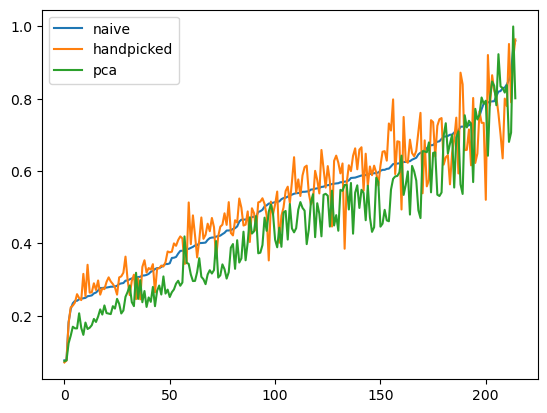

In [9]:
four_d_var_filtered = np.array(four_d_var)[reasonable_rate_ind]
var_naive_list_filtered = np.array(var_naive_list)[reasonable_rate_ind]
pca_filt = np.array(pca_list)[reasonable_rate_ind]
sorted_vars = np.argsort(var_naive_list_filtered)
plt.plot(var_naive_list_filtered[sorted_vars], label='naive')
plt.plot(four_d_var_filtered[sorted_vars], label='handpicked')
plt.plot(pca_filt[sorted_vars], label='pca')
plt.legend()

# include pca version in variance computation function, use first 4 components at first, then use spectrum
# compute variance (remember axis = 0)
# plot similar to the figures below
# look at neurons that are most different between two curves in terms of their sorted order among all templates
# for ex: if one metric says a template has low variance, vs another says high variance --> look at spikes
# want to check if any of the metrics agrees with our visiual perception / intuition
# use alpha parameter to make plot as curves would be semi-transparent. then mean will be stronger (curves overlapping)


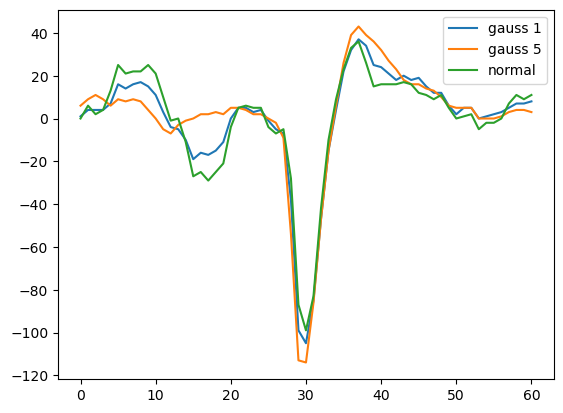

In [7]:
# creating Gaussian blur

t_num = 0

# constants
SAMP_RATE = 30 # samples per ms
half_ms_len = int(round(.5 * SAMP_RATE))
slope_delta = int(round(SAMP_RATE/10.))

# getting waves for each template (default 0)
longwaves = np.squeeze(get_long_spike_windows_per_template(t_num))
waves = np.squeeze(get_spike_windows_per_template(t_num))
unfilt_waves = np.squeeze(get_spike_windows_per_template(t_num, data_array=data_array_unfilt))

gauss_1 = gaussian_filter(waves, sigma=1, axes=0)
gauss_5 = gaussian_filter(waves, sigma=5, axes=0)

plt.plot(gauss_1[0], label='gauss 1')
plt.plot(gauss_5[0], label='gauss 5')
plt.plot(waves[0], label='normal')
plt.legend()


In [13]:
# analysis of waveforms for each method

# todo: filter with gaussian blur and also try with unfiltered data
# also plot the 4d characteristics w/ legend etc

# for naive: can weight each time point either using gaussian or look at a small window bc this is lower power 
# make plot with variance of 0-120 etc
# set y limits to be min y on LB and max y on UB.

def generate_sorted_waves(waves, calc_var = False):

    # getting mean for each metric
    pca = PCA(n_components=4)
    pcs = pca.fit_transform(waves)
    mean_naive = waves.mean(axis=0)
    mean_pca = pcs.mean(axis=0)
    all_4d = []
    
    for wave in waves:
    
        dp_val, dp_t = np.min(wave[2:-slope_delta - half_ms_len]), np.argmin(wave[2:-slope_delta - half_ms_len]) + 2
        ahp_val, ahp_t = np.max(wave[dp_t+1:]),np.argmax(wave[dp_t+1:]) #peak after trough
        bhp_val = np.max(wave[:dp_t])
            
        params = np.empty(4) # 4 columns for: after-hyper:depolar ratio, 
                                # trough to after-hyper time, slope 0.5 ms after trough
    
        params[0] = ahp_val/dp_val;
        params[1] = ahp_t/SAMP_RATE;
        params[3] = bhp_val/-dp_val
    
        slope_t = dp_t+half_ms_len
        interval = slope_t - slope_delta, slope_t + slope_delta
    
        # #slope at (dp_t + half_ms_len) == dp_t + 0.5 ms
        params[2] = (wave[interval[1]] - wave[interval[0]])/((interval[1] - interval[0])/SAMP_RATE)
    
        all_4d.append(params)
    
    mean_4d = np.mean(all_4d, axis=0)
    
    # getting distance for all waves from the 3 means
    naive_dists, four_d_dists, pca_dists = [], [], []
    for i, wave in enumerate(waves):
        
        naive_dists.append((np.linalg.norm(wave - mean_naive), i))
        four_d_dists.append((np.linalg.norm(all_4d[i] - mean_4d), i))
        pca_dists.append((np.linalg.norm(np.squeeze(pca.transform([wave])) - mean_pca), i))
    
    # sorting by dist to mean
    naive_dists = sorted(naive_dists, key=lambda x: x[0])
    four_d_dists = sorted(four_d_dists, key=lambda x: x[0])
    pca_dists = sorted(pca_dists, key=lambda x: x[0])
    

    if not calc_var:   
        # creating 16 evenly spaced indices   
        indices = np.linspace(0, len(waves) - 1, 17).round().astype(int) 
        return naive_dists, four_d_dists, pca_dists, indices

    else:

        # creating 17 evenly spaced indices --> 16 plots   
        indices = np.linspace(0, len(waves) - 1, 17).round().astype(int) 
        std_naive, std_4d, std_pca = [], [], []

        s = indices[0]
        for f in indices[1:]:
            _, i_naive = zip(*naive_dists[s:f])
            _, i_4d = zip(*four_d_dists[s:f])
            _, i_pca = zip(*pca_dists[s:f])
            std_naive.append(np.sqrt(np.var(waves[list(i_naive)], axis=0)))
            std_4d.append(np.sqrt(np.var(waves[list(i_4d)], axis=0)))
            std_pca.append(np.sqrt(np.var(waves[list(i_pca)], axis=0)))
            s = f

        return std_naive, std_4d, std_pca, indices

naive_dists_l, four_d_dists_l, pca_dists_l, indices_l = generate_sorted_waves(longwaves)
naive_dists_u, four_d_dists_u, pca_dists_u, indices_u = generate_sorted_waves(unfilt_waves)
naive_dists, four_d_dists, pca_dists, indices = generate_sorted_waves(waves)
naive_g1, four_d_g1, pca_g1, ind_g1 = generate_sorted_waves(gauss_1)
naive_g5, four_d_g5, pca_g5, ind_g5 = generate_sorted_waves(gauss_5)
std_naive, std_4d, std_pca, ind_std = generate_sorted_waves(waves, True)
std_naive_l, std_4d_l, std_pca_l, ind_std_l = generate_sorted_waves(longwaves, True)
std_naive_u, std_4d_u, std_pca_u, ind_std_u = generate_sorted_waves(unfilt_waves, True)

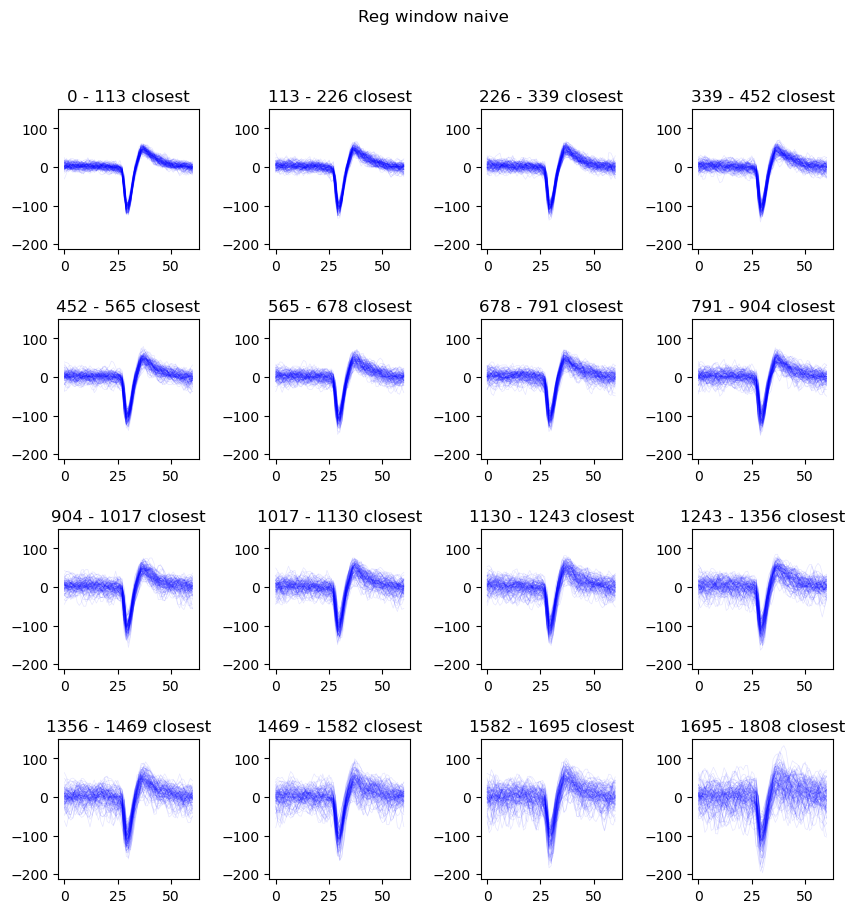

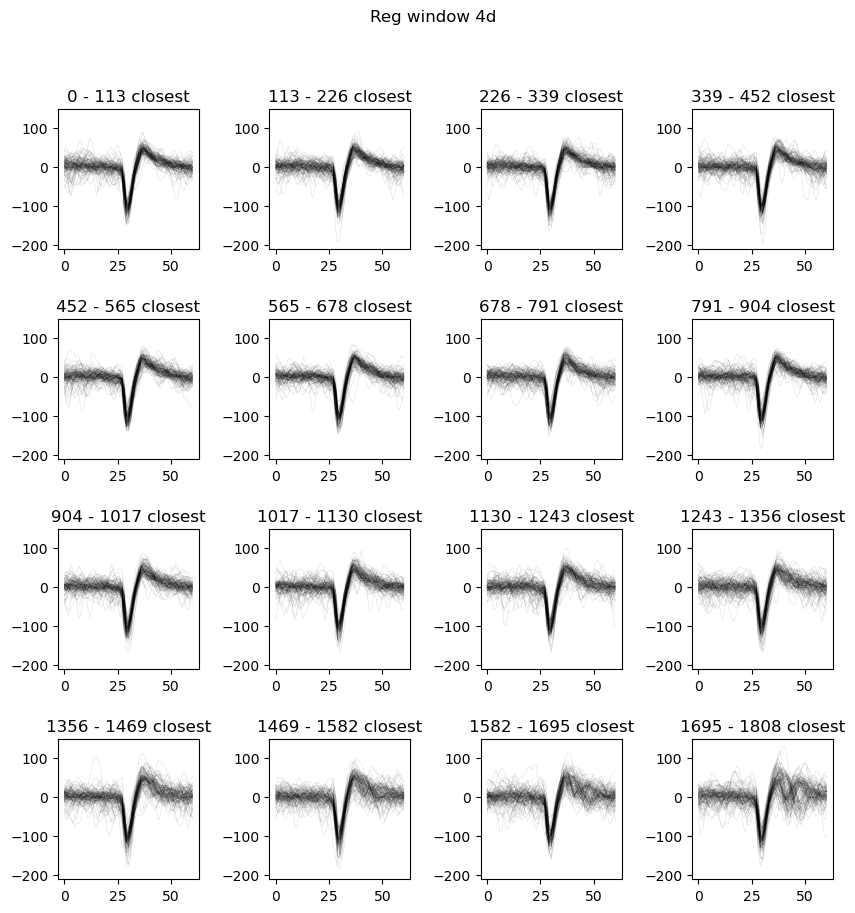

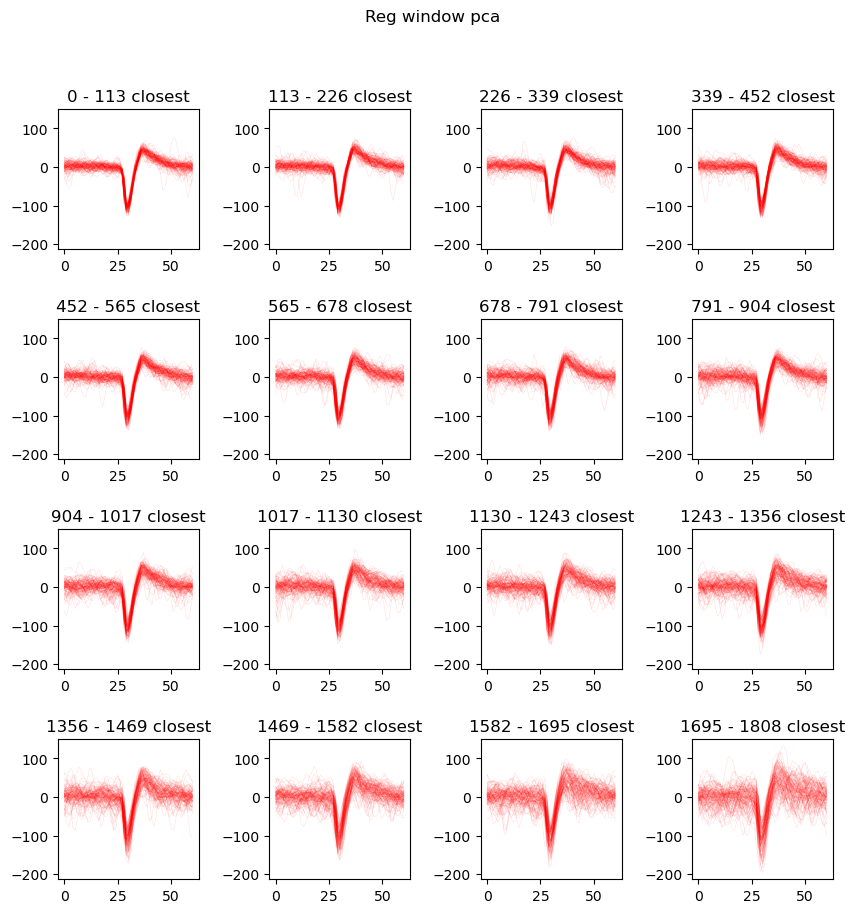

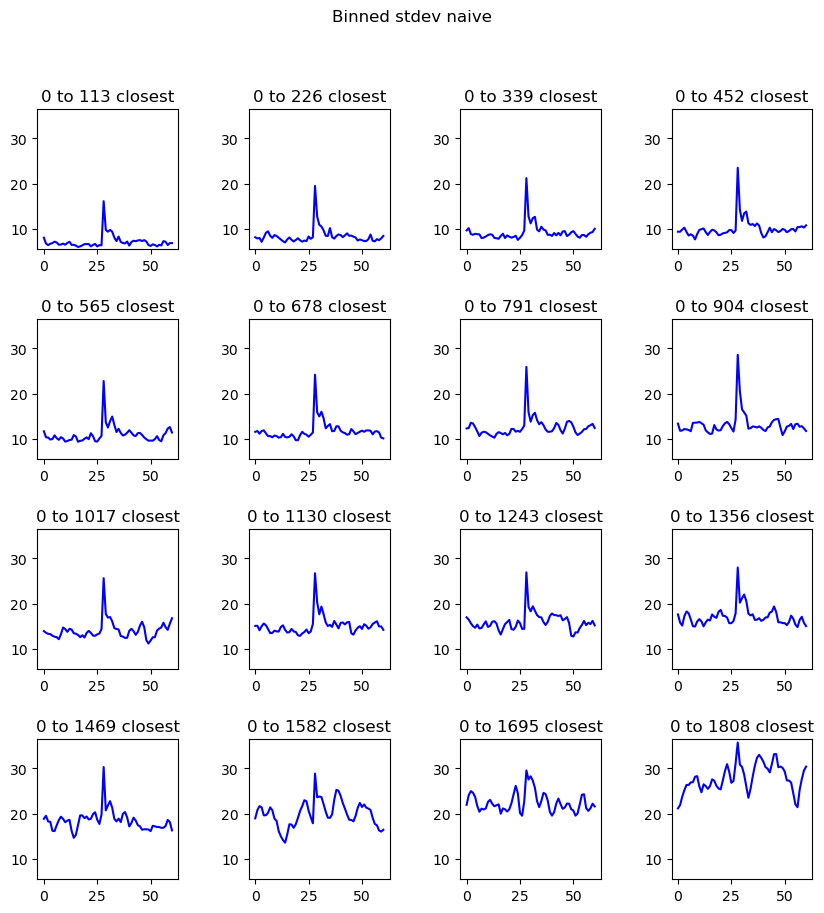

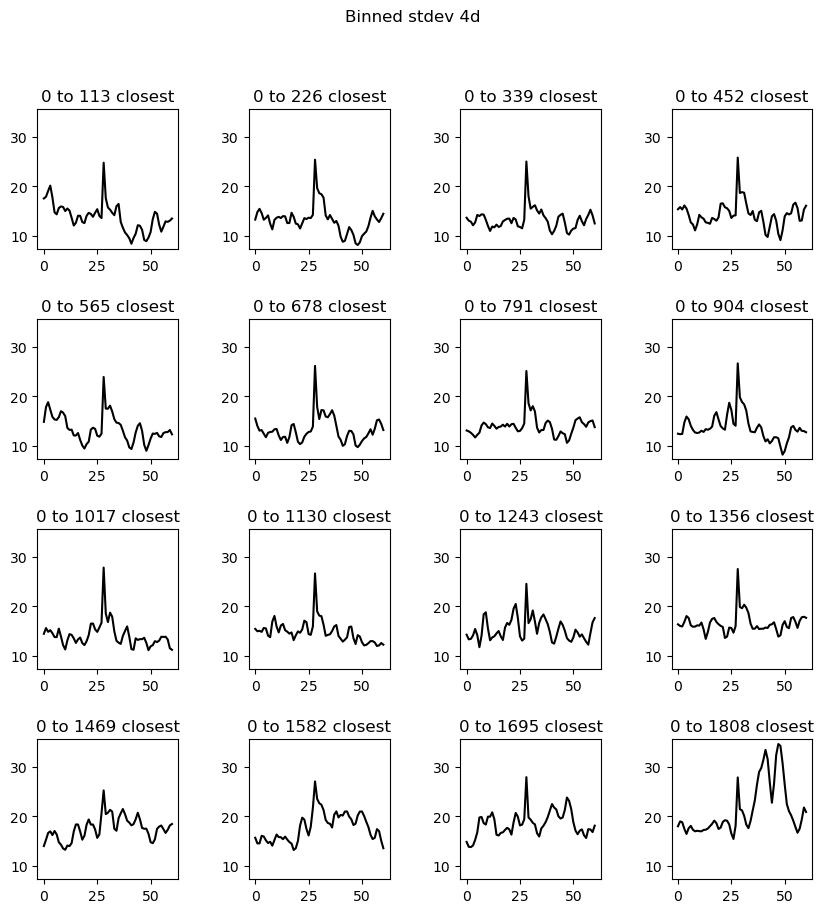

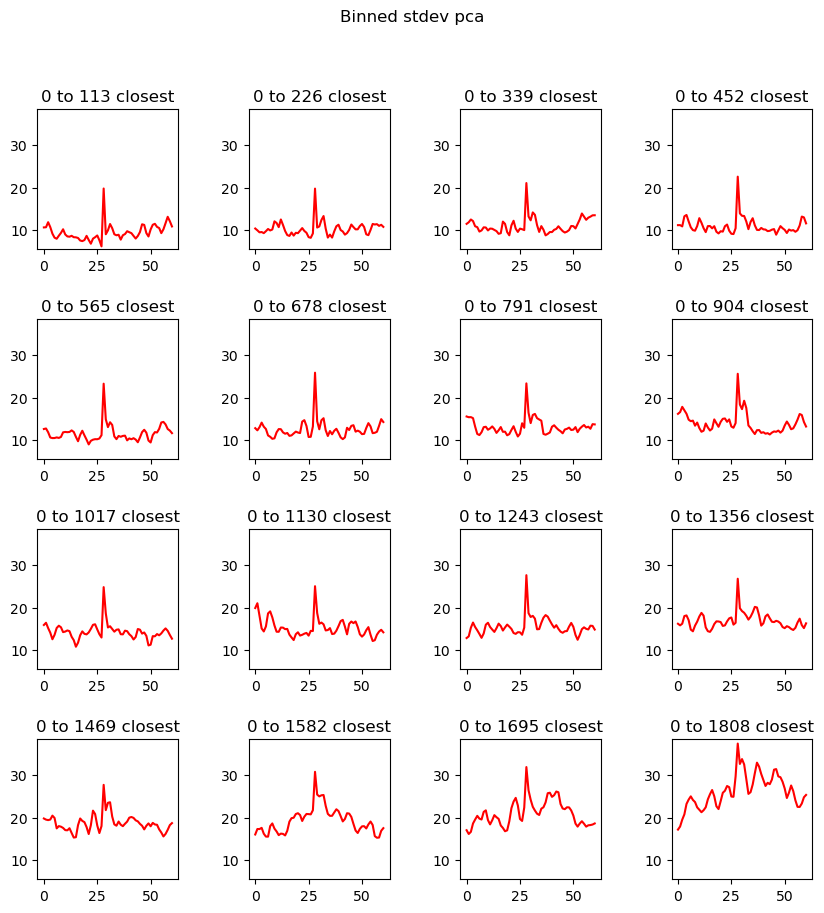

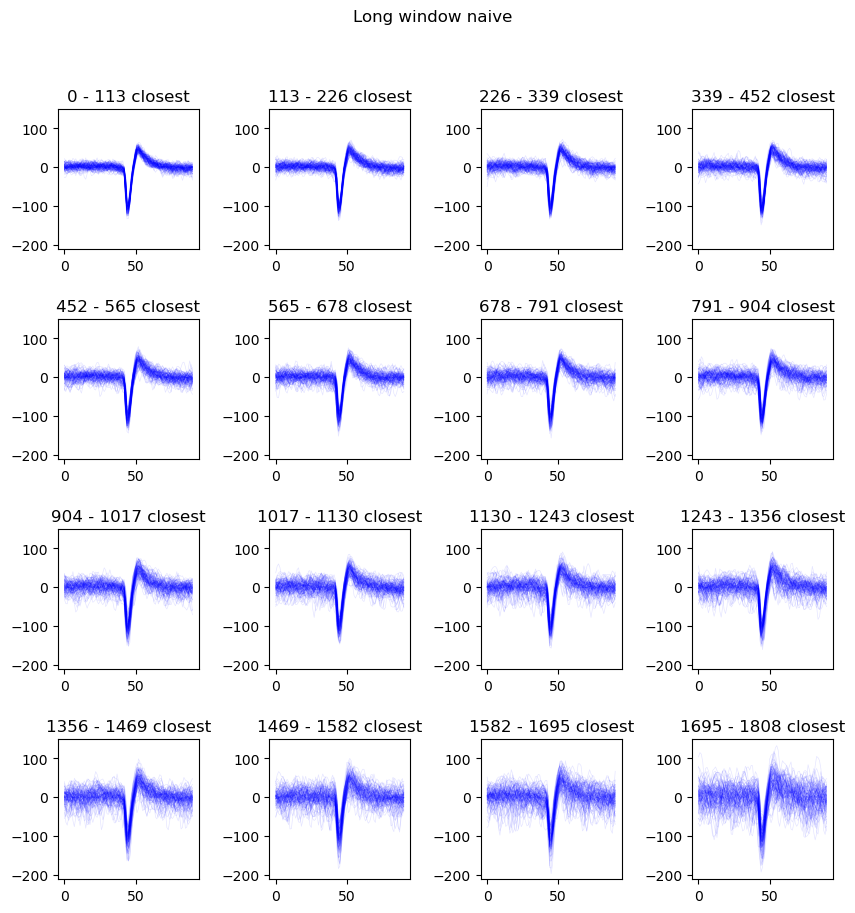

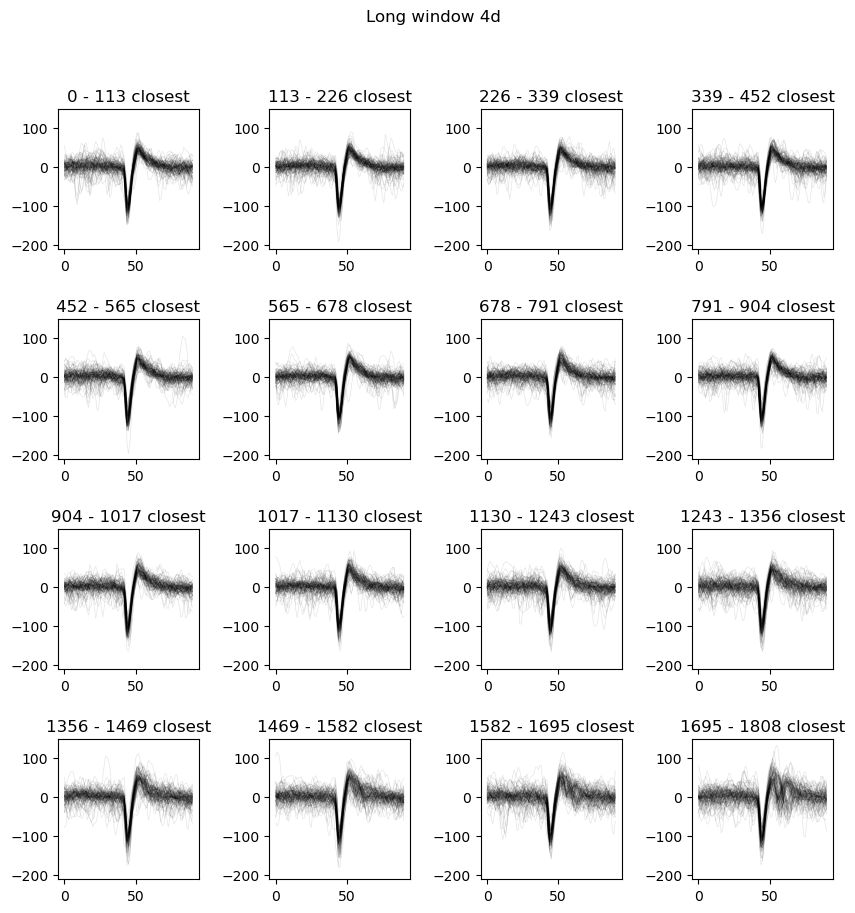

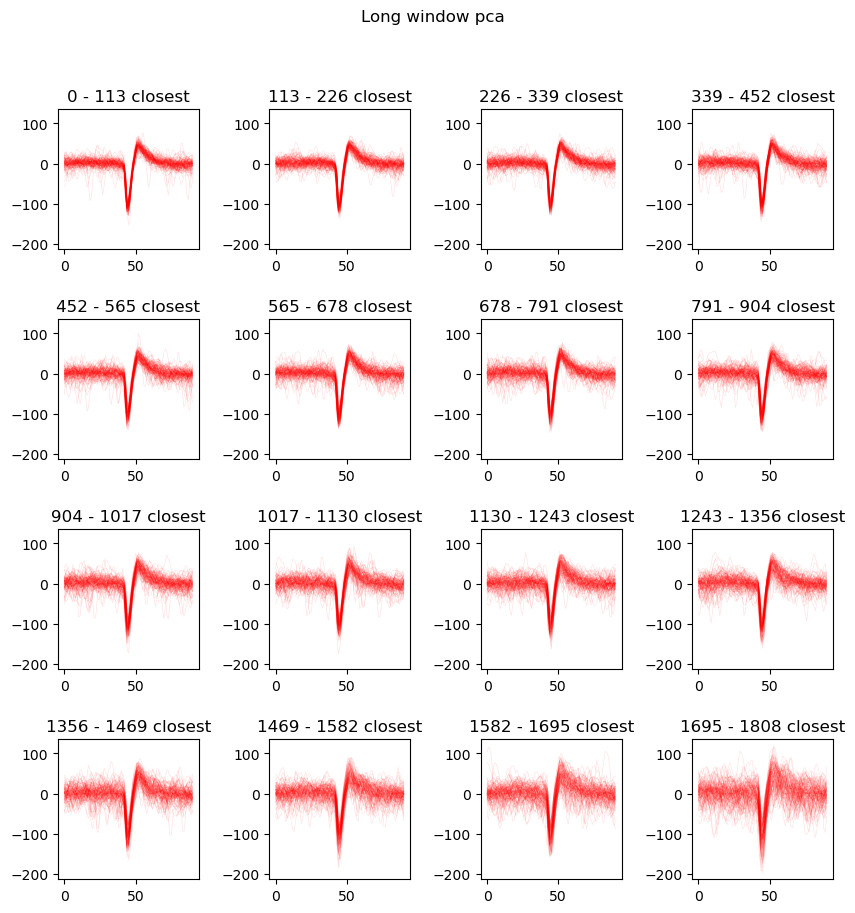

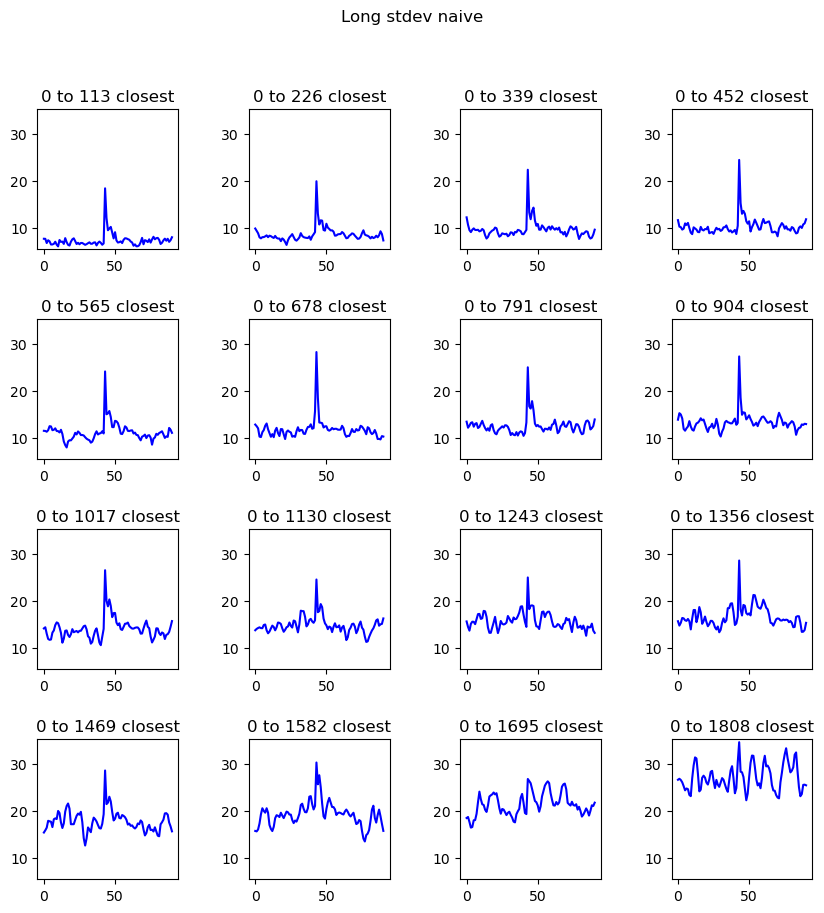

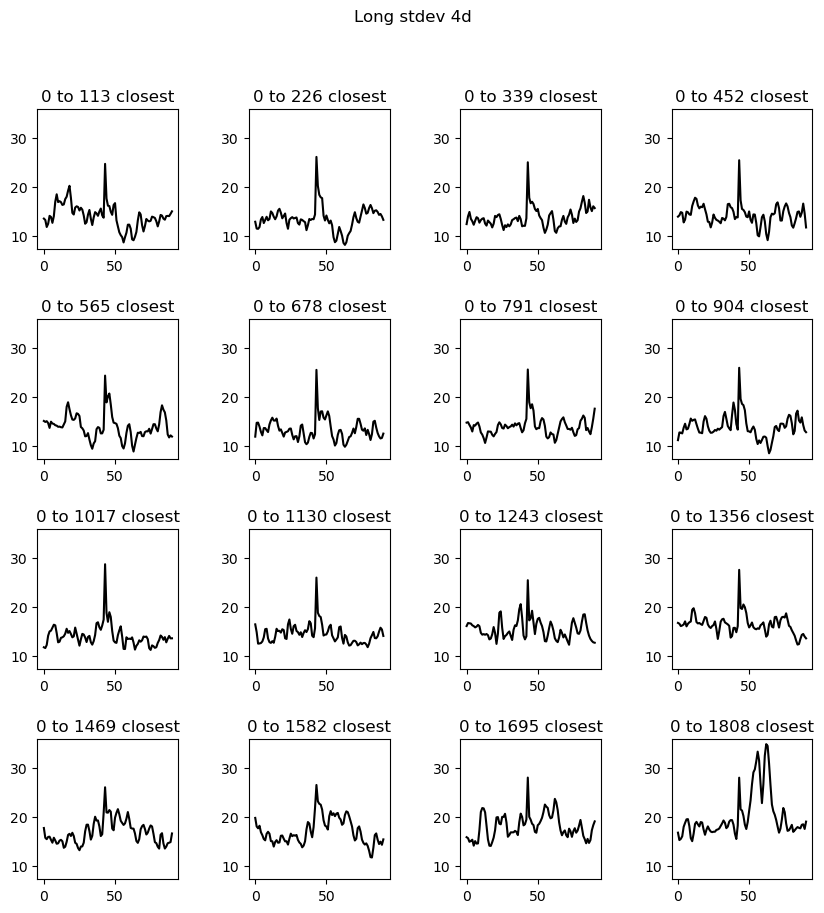

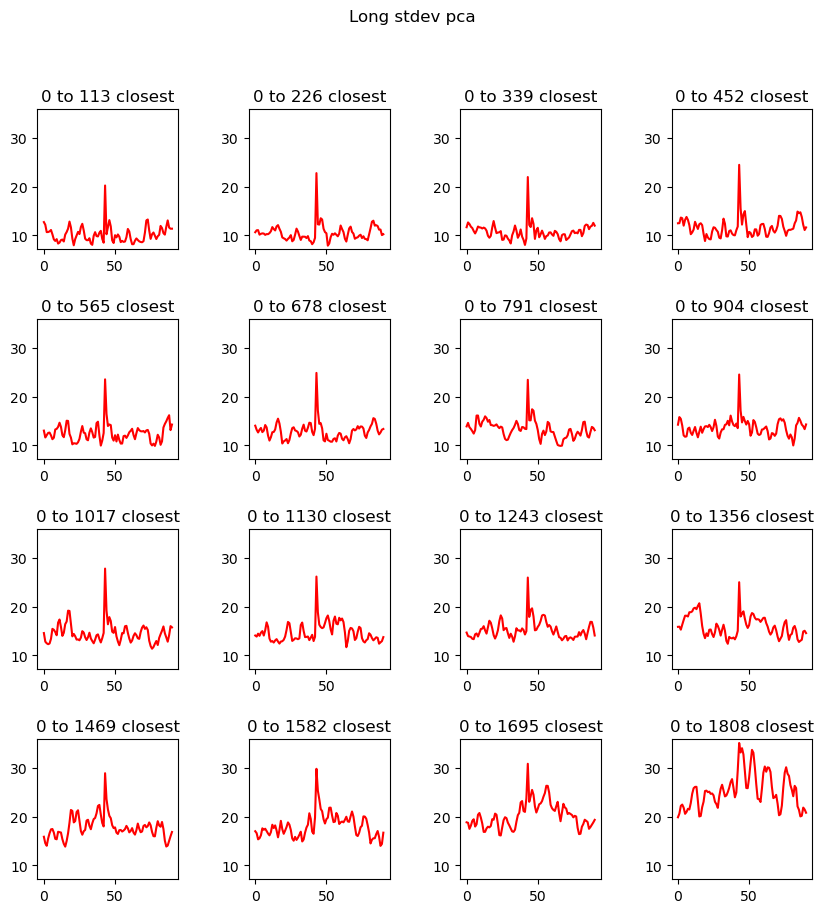

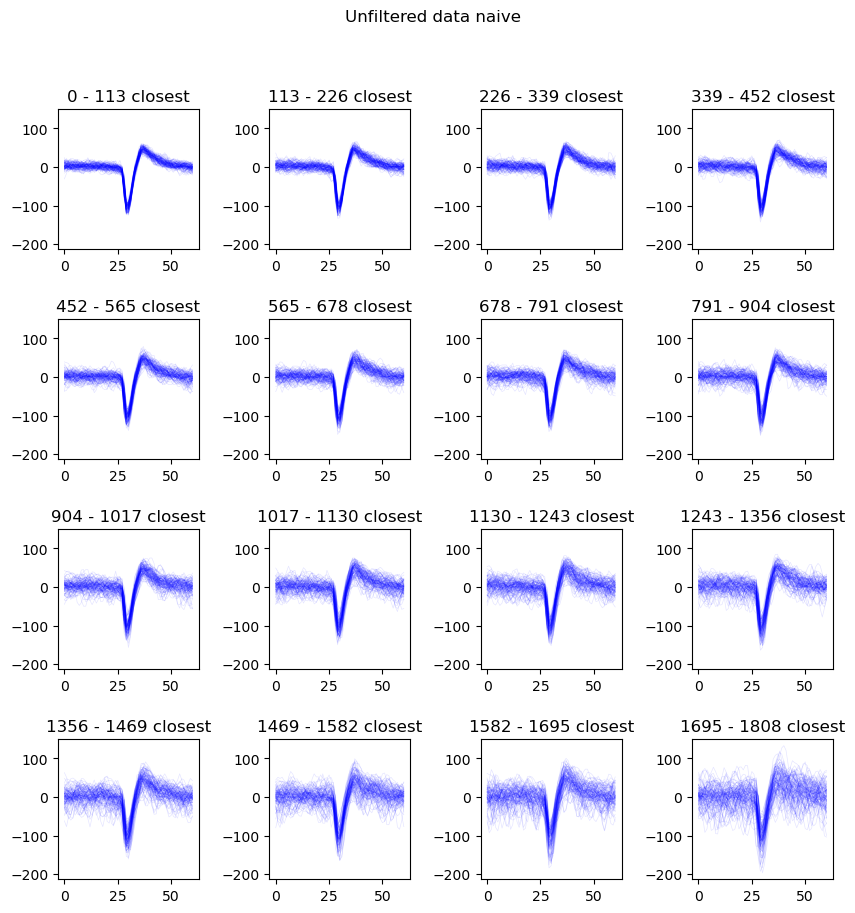

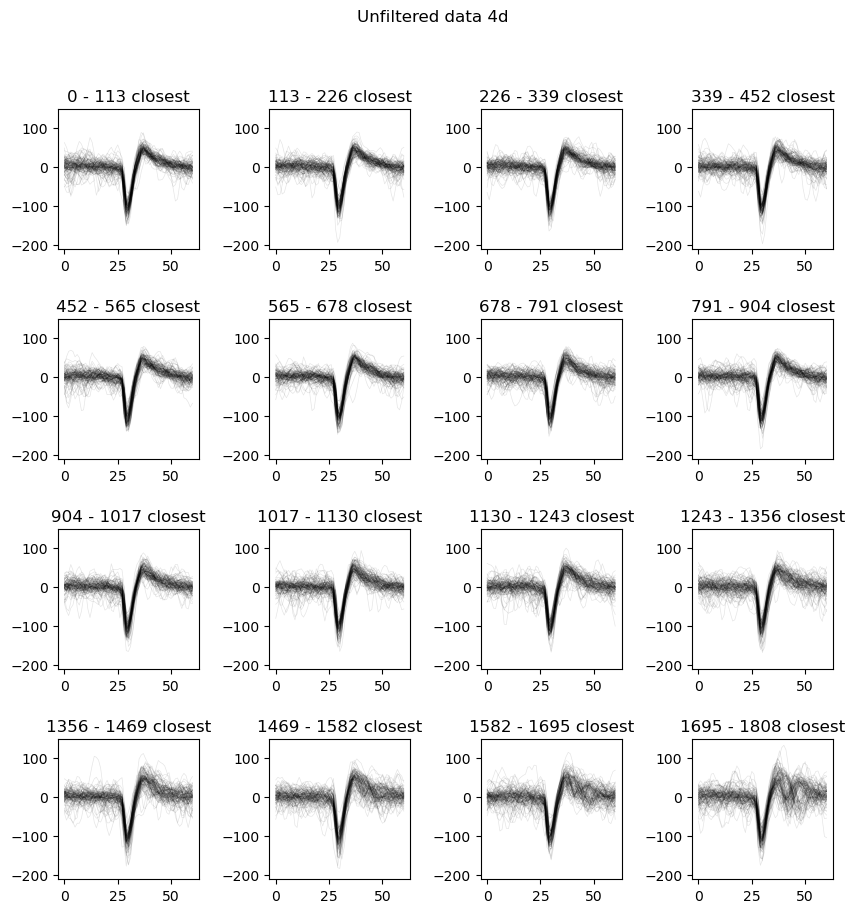

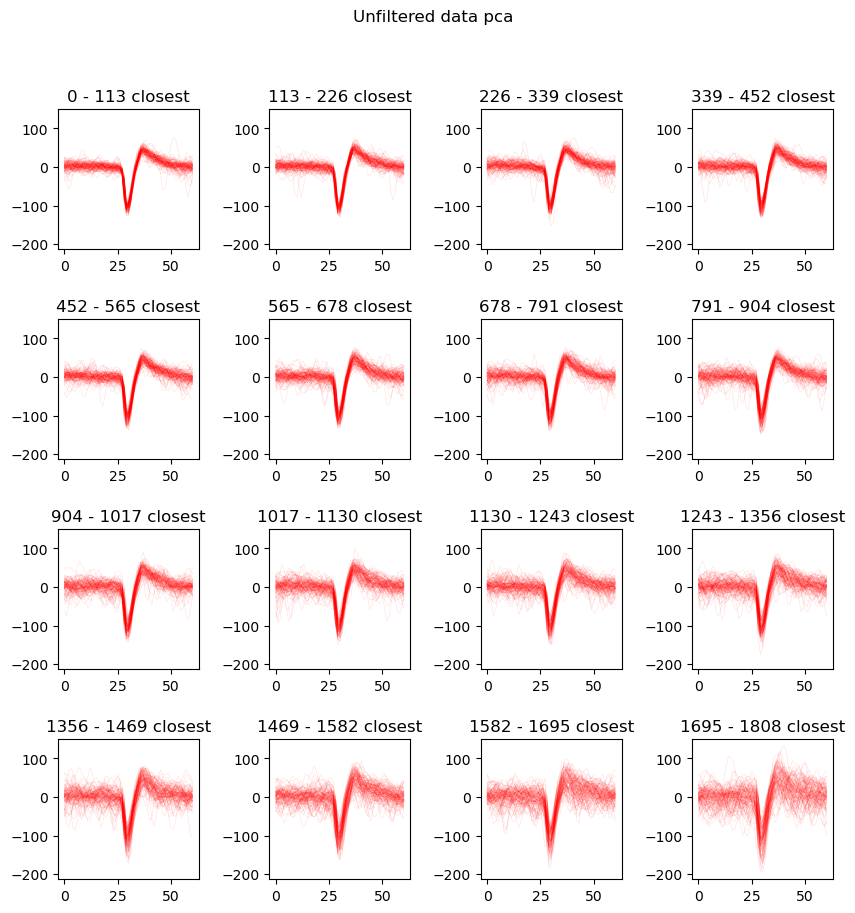

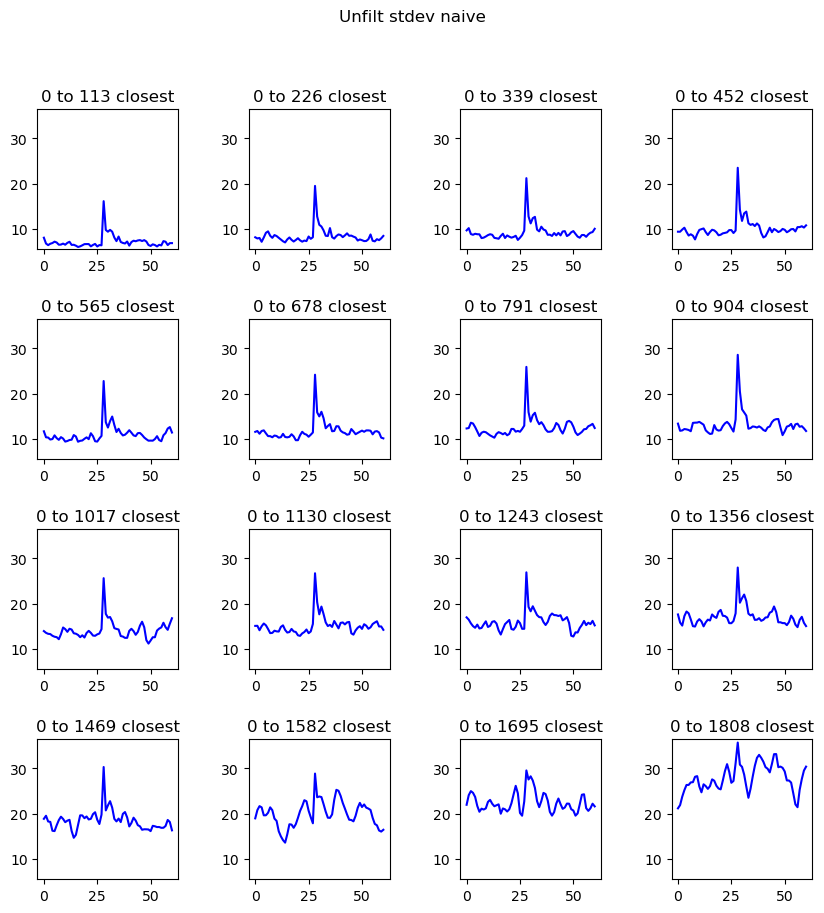

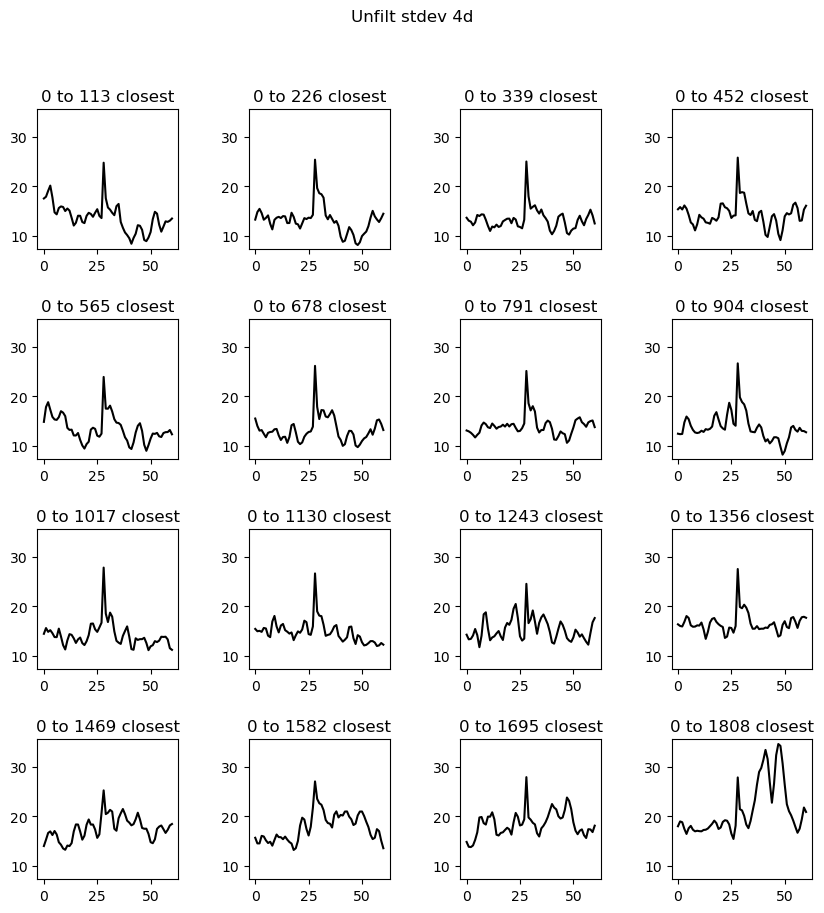

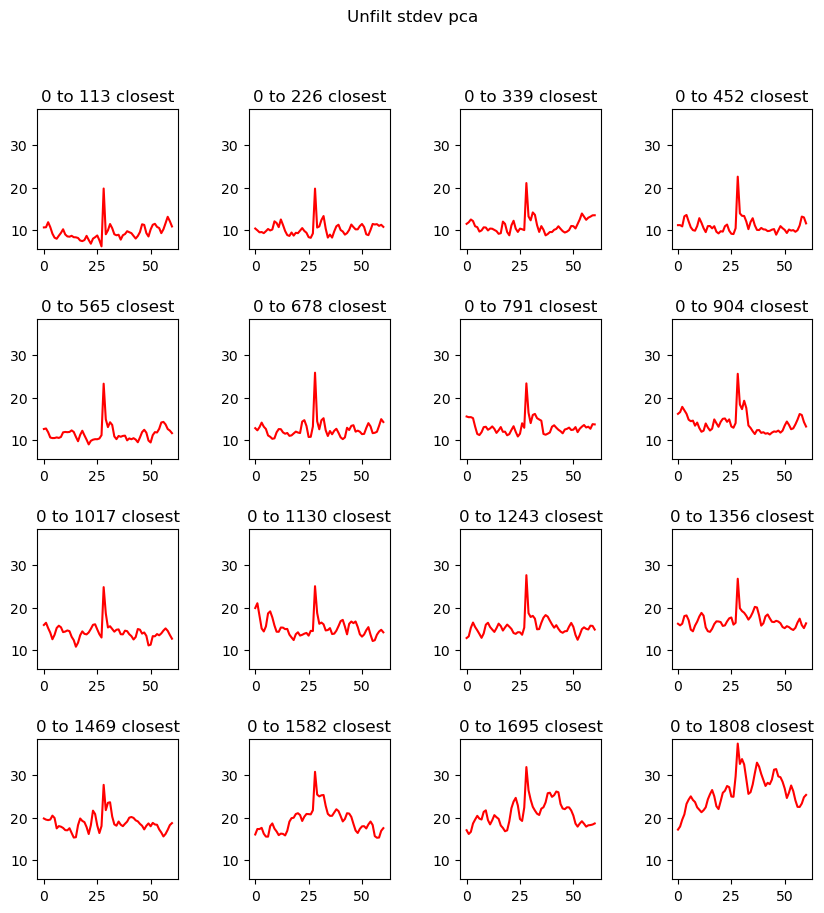

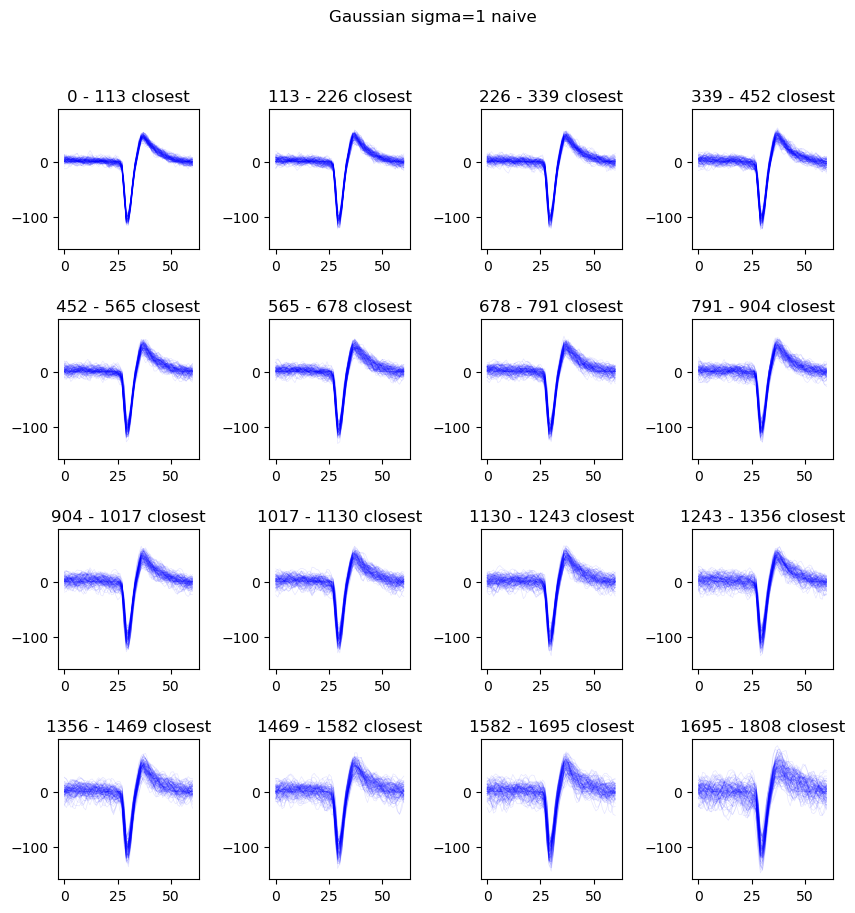

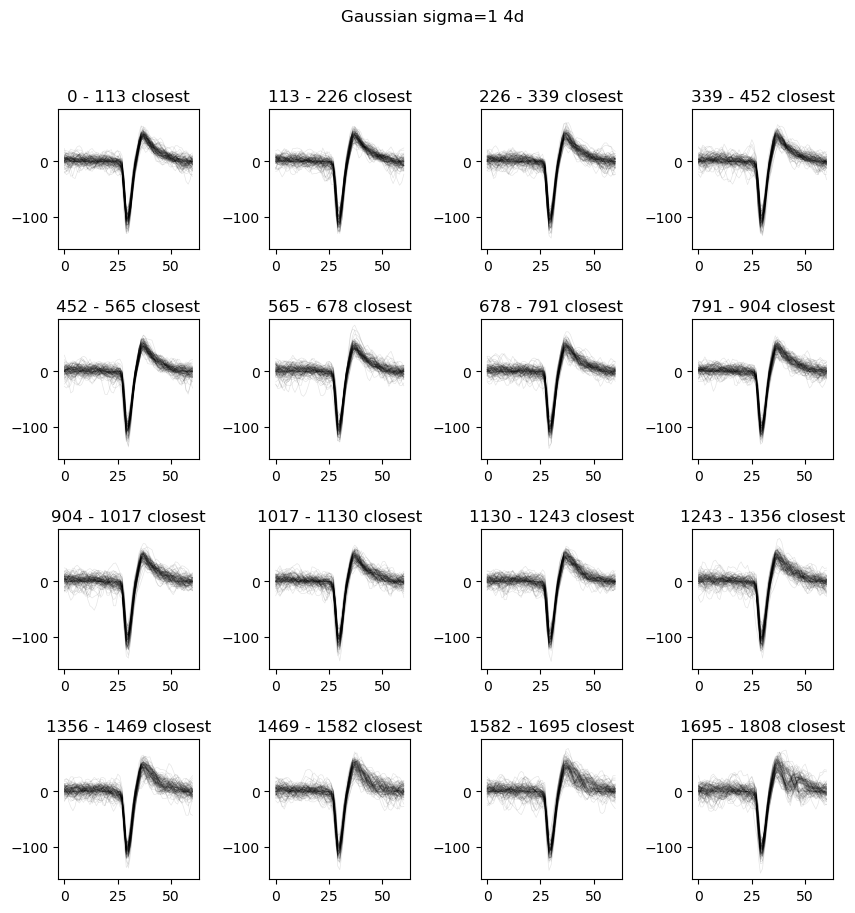

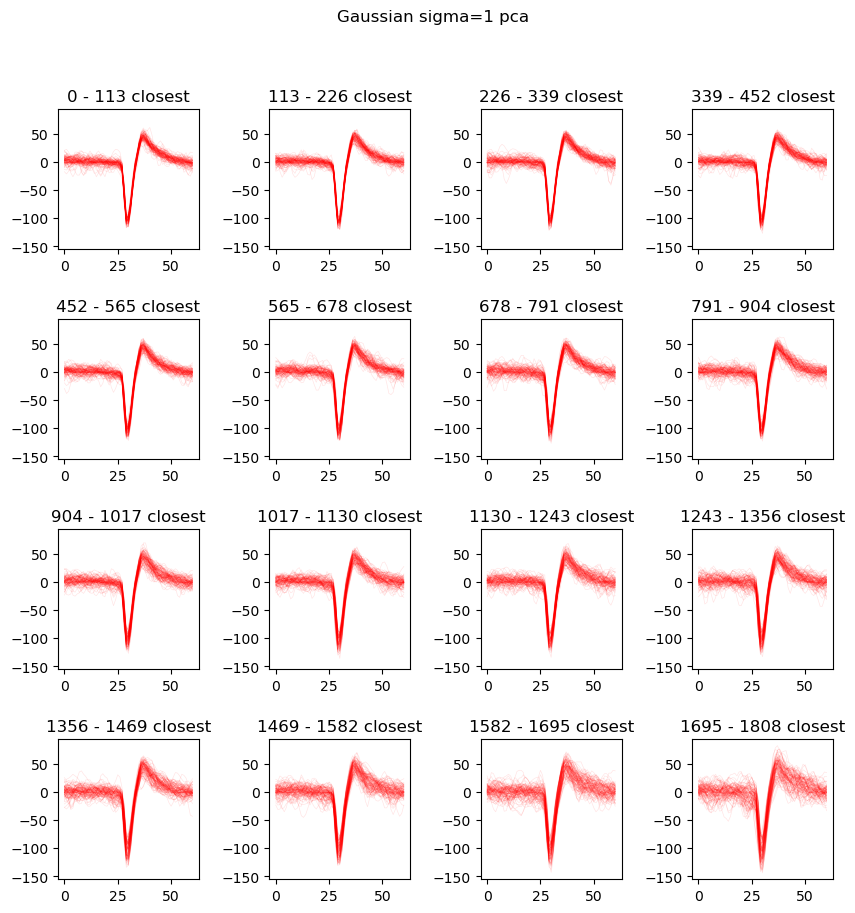

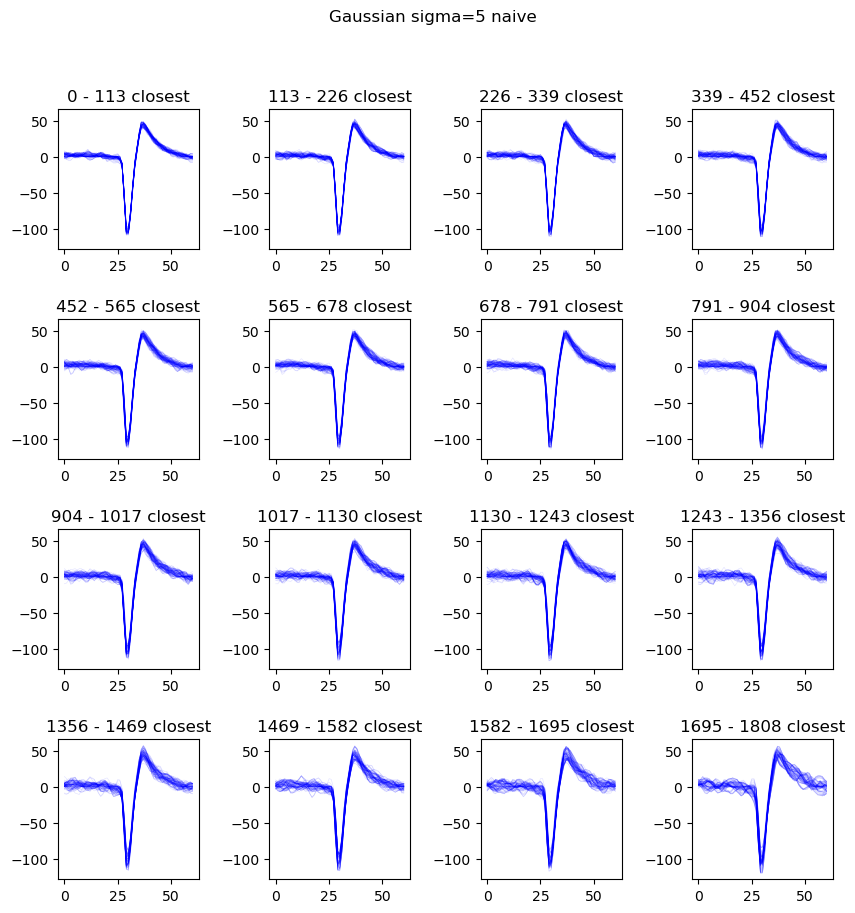

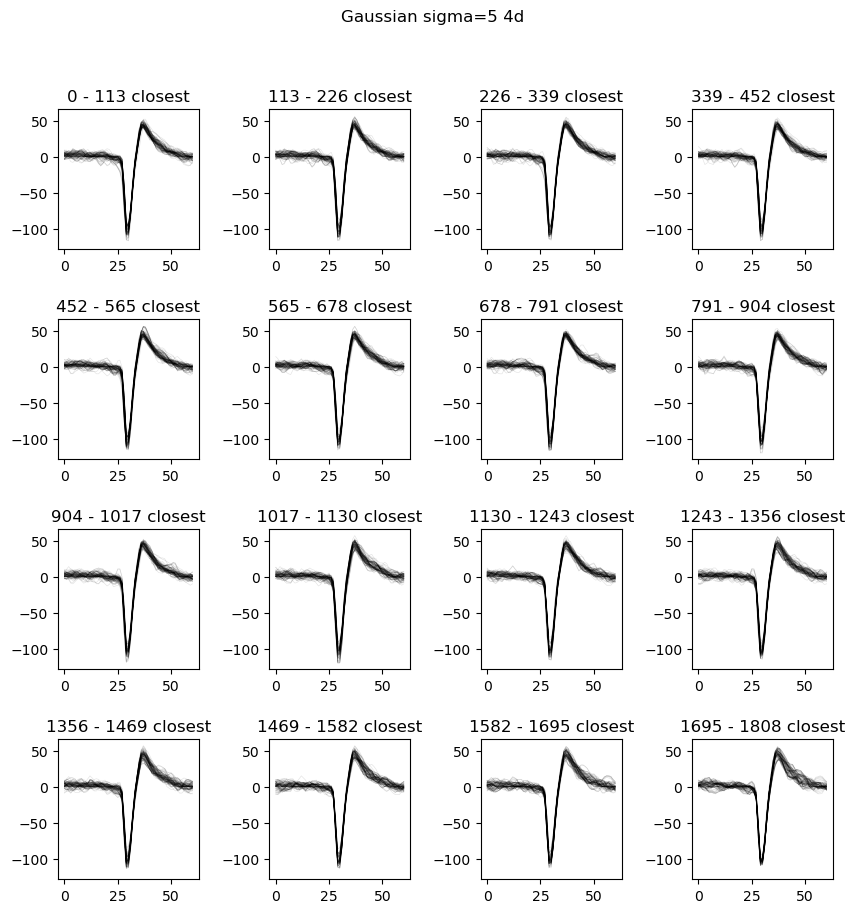

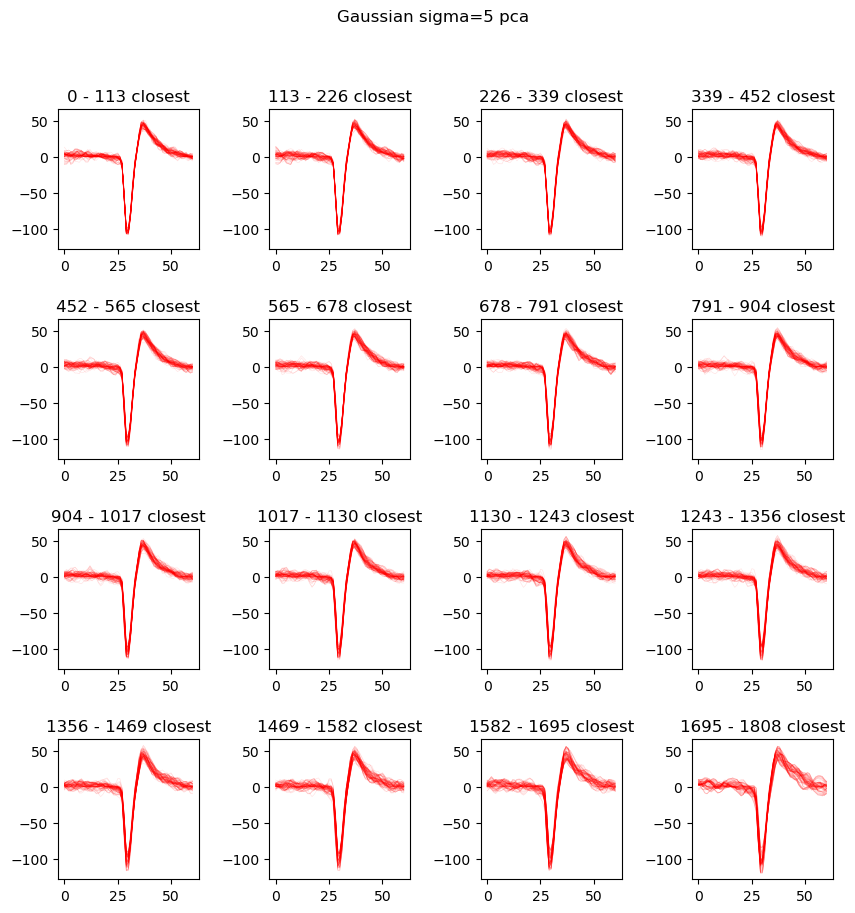

In [17]:
# what's the expected var of mag of spike
# plot all in bin with low alpha. if you can't see anything, double the number of plots.
# do naive for short window (31 or 25)
# is it possible / easy to identify which spikes were found after deconv. step
# put label next to each plot—what is the (weighted by gaussian, np.average) mean stdev across time in each group
# then have supplementary plot of weighted sigma across time
# choose threshold using ground truth data and then we can see what the threshold is for each of these plots
# take extracellular data and run through kilosort. figure out the probe. repeat everything i'm doing with the new data. 

def plot_waveforms(waves, dists, indices, color, title):
    ylow, yhigh, axes = [], [], []
    fig = plt.figure(figsize=(10,10), dpi=100)
    grid = gridspec.GridSpec(4, 4, figure=fig, hspace=0.5, wspace=0.5)

    s = indices[0]
    for i, f in enumerate(indices[1:]):
        axes.append(fig.add_subplot(grid[i // 4, i % 4]))

        _, i_bin = zip(*dists[s:f])
        nb=axes[-1].plot(waves[list(i_bin)].T, color=color, alpha=0.1, lw=0.5)
        axes[-1].set_title(f'{s} - {f} closest')
        _, _, yl, yh = axes[-1].axis()
        ylow.append(yl)
        yhigh.append(yh)
        s = f
    
    for ax in axes:
        ax.set_ylim([min(ylow), max(yhigh)])
    
    plt.suptitle(title)
    plt.savefig(title)

    plt.show()

def plot_std_of_bin(std, indices, color, title):
    ylow, yhigh, axes = [], [], []
    fig = plt.figure(figsize=(10,10), dpi=100)
    grid = gridspec.GridSpec(4, 4, figure=fig, hspace=0.5, wspace=0.5)

    s = indices[0]
    for i, f in enumerate(indices[1:]):
        axes.append(fig.add_subplot(grid[i // 4, i % 4]))
        nb=axes[-1].plot(std[i], color=color)
        axes[-1].set_title(f'{s} to {f} closest')
        _, _, yl, yh = axes[-1].axis()
        ylow.append(yl)
        yhigh.append(yh)
    
    for ax in axes:
        ax.set_ylim([min(ylow), max(yhigh)])
    
    plt.suptitle(title)
    plt.savefig(title)

    plt.show()
    
plot_waveforms(waves, naive_dists, indices, 'b', 'Reg window naive')
plot_waveforms(waves, four_d_dists, indices, 'k', 'Reg window 4d')
plot_waveforms(waves, pca_dists, indices, 'r', 'Reg window pca')

plot_std_of_bin(std_naive, ind_std, 'b', 'Binned stdev naive')
plot_std_of_bin(std_4d, ind_std, 'k', 'Binned stdev 4d')
plot_std_of_bin(std_pca, ind_std, 'r', 'Binned stdev pca')

plot_waveforms(longwaves, naive_dists_l, indices, 'b', 'Long window naive')
plot_waveforms(longwaves, four_d_dists_l, indices, 'k', 'Long window 4d')
plot_waveforms(longwaves, pca_dists_l, indices, 'r', 'Long window pca')

plot_std_of_bin(std_naive_l, ind_std, 'b', 'Long stdev naive')
plot_std_of_bin(std_4d_l, ind_std, 'k', 'Long stdev 4d')
plot_std_of_bin(std_pca_l, ind_std, 'r', 'Long stdev pca')

plot_waveforms(unfilt_waves, naive_dists_u, indices_u, 'b', 'Unfiltered data naive')
plot_waveforms(unfilt_waves, four_d_dists_u, indices_u, 'k', 'Unfiltered data 4d')
plot_waveforms(unfilt_waves, pca_dists_u, indices_u, 'r', 'Unfiltered data pca')

plot_std_of_bin(std_naive_u, ind_std, 'b', 'Unfilt stdev naive')
plot_std_of_bin(std_4d_u, ind_std, 'k', 'Unfilt stdev 4d')
plot_std_of_bin(std_pca_u, ind_std, 'r', 'Unfilt stdev pca')

plot_waveforms(gauss_1, naive_g1, ind_g1, 'b', 'Gaussian sigma=1 naive')
plot_waveforms(gauss_1, four_d_g1, ind_g1, 'k', 'Gaussian sigma=1 4d')
plot_waveforms(gauss_1, pca_g1, ind_g1, 'r', 'Gaussian sigma=1 pca')

plot_waveforms(gauss_5, naive_g5, ind_g5, 'b', 'Gaussian sigma=5 naive')
plot_waveforms(gauss_5, four_d_g5, ind_g5, 'k', 'Gaussian sigma=5 4d')
plot_waveforms(gauss_5, pca_g5, ind_g5, 'r', 'Gaussian sigma=5 pca')

In [10]:
plt.close('all')

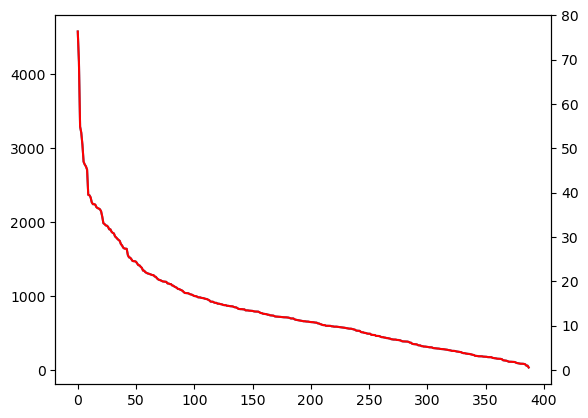

In [26]:
lens = np.array(lens)
sorted_lens = np.argsort(lens)[::-1]
ax = plt.subplot(111)
# ax.plot(lens[sorted_lens])
ax_ = ax.twinx()
# ax_.plot(contam_pct[sorted_lens], 'r-')

total_rec_time = 60 # in seconds

firing_rates = lens / total_rec_time

ax_.plot(firing_rates[sorted_lens], 'r-')

ax.plot(lens[sorted_lens])

In [47]:
total_rec_time

3773.6256

In [39]:
sorted_lens

array([330, 184, 252,   7,  62,  24, 316,  85,  80,  11, 304,  19,  33,
       122,  44,   9, 271, 373, 198,  21, 151,  23, 292, 358, 386,   8,
         6, 248,  51, 382,  14, 193,   0, 170, 113, 365, 319,  17, 307,
       372, 171,   5,  57,  48, 229, 144, 104, 135,  16, 356,  15, 241,
       306, 256, 328, 139, 204, 134,  38, 161,  28, 157, 177, 350, 305,
       162, 293, 250, 253, 219,  41, 132,  52,  43,   3, 195, 205, 172,
       233,  20,  90, 313, 194, 327,  63, 346,  95,  72, 210,  31, 150,
        65,  22,  37,  45, 342, 102,  49, 192,  29, 230, 119, 366, 225,
       179,  58, 349,  96, 263, 249, 145, 290,  88,  87, 326,  89, 343,
       259, 124, 101, 147, 220, 183,  18,  67, 352, 115,  84, 141, 381,
       235, 148, 333, 180,  60, 167,  92, 334, 129, 322, 125, 146,  73,
        34, 136,  25, 270, 321, 329, 114, 227, 108, 166, 223, 315, 291,
       282, 131,  12, 143,  70, 317,  91,  47, 379, 320,   2, 163,   1,
       178, 245, 353,  71, 323,  10, 335, 118, 285,  35,  69, 37

In [33]:
dp_t, dp_val

(0, -81)

In [34]:
wave

array([-45, -73, -81, -72, -57, -37, -14,   3,  12,   6,  14,  17,  20,
        29,  21,  12,   8,   7,   9,  18,  29,  27,  19,  14,   8, -13,
       -12,  -5,  -2,   7,  17,  21,  20,  18,  12,  -5,  -9, -21, -20,
       -10,   5,   9,   5,   0, -34, -66, -74, -48, -33, -16,  -9,  -6,
         2,  15,  33,  52,  55,  55,  66,  63,  52,  24,  16,  11,  14,
        19,  10,   0,  -8, -24, -34, -38, -35, -17,  -7, -14, -10,  -2,
         2,   8,   0, -16, -25, -28, -23, -16,  -4,  20,  25,  32,  32],
      dtype=int16)

In [14]:
interval

(70, 76)

In [24]:
slope_t

88

In [26]:
wave.size

91

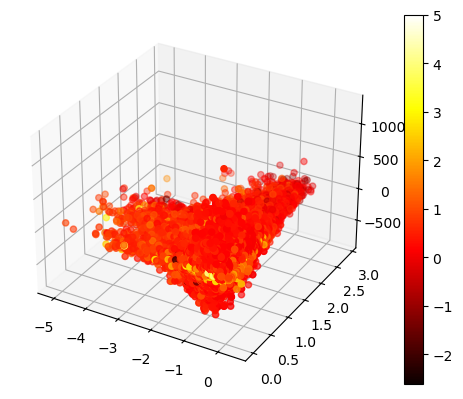

In [37]:
# plotting params all params with 4th as a color bar
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z, c = zip(*X)

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

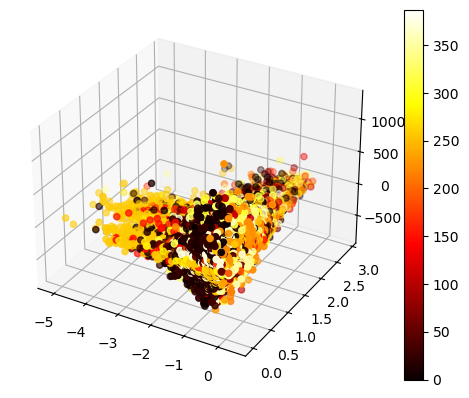

In [38]:
#plotting 0, 1, 2 with color = template number
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y, z, _ = zip(*X)

img = ax.scatter(x, y, z, c=X_is, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [43]:
# naive vs 4d var

for t_num in tqdm(range(len(templates))):

    # getting longer spike window
    waves = get_long_spike_windows_per_template(t_num)

    print(summed_var)


  7%|▋         | 26/388 [00:00<00:02, 126.57it/s]

737.2539092069007
470.52651108798034
222.1307400200799
nan
561.7777885786325
981.0069593421488
nan
314.07333676367955
304.81680769097295
624.6900607472725
517.2915030055415
267.81462173722383
238.35698187169083
221.59416540223495
263.63266658958275
483.1784983754023
280.7229900434701
284.090705543024
213.3296887606803
313.8698248355822
314.2177148793713
457.1842304747359
215.24781605892852
453.4718165592583
nan
301.52089974792875
227.21908240459192
328.35900542816296


 18%|█▊        | 68/388 [00:00<00:01, 180.47it/s]

419.74174510451905
122.54916948278189
293.92787074499455
209.9213776745804
498.93439711787
142.2085671296327
129.5586624649611
483.410126371214
160.26693511860822
158.4818622350726
163.18613151982848
142.92805193523236
144.93368246052847
134.32030260890312
159.46690802366865
203.83872202900884
88.05612006835652
123.04610909722535
128.98189833342232
120.68625494162004
133.68811720985175
149.02427352233178
103.281050420422
126.15502420508413
238.67205947428096
90.52298799920929
117.17084259147447
112.69375067184666
87.77915566824981
155.64422279990848
157.90656003770704
116.46014917276341
136.44443624381114
145.18583256351403
125.44839380010042
90.59063179974794
158.8341090015348
73.62713907246221
151.49969792027628
276.89521926928654
106.51962805969285
75.97854122505248


 31%|███       | 119/388 [00:00<00:01, 224.02it/s]

84.13944528065043
100.11467328980021
65.78627467623832
122.54298106588928
104.44936280203028
76.6641392872545
65.3339780090164
75.99842888441452
nan
146.3788795160676
56.59076143597447
105.6024392867688
330.83808266975774
211.06297889039712
206.36121054794654
575.4200461839648
256.6159613255997
358.42360678441156
296.56106418211203
299.4797592720808
494.52501059471706
362.8530967404702
271.4558419588727
259.9348997444359
706.3493726269465
218.97061793236557
313.00955309818244
340.63697418305486
374.0563398340939
657.6188788306544
690.8128941037983
994.2822022576144
817.9912576027958
405.31108095839863
856.8562223461942
646.4955699405336
374.29704253149544
393.4141518839771
967.319257421392
467.68406318407807
931.5608309248195
513.7972683910552
476.5312471327601
305.48610311455116
462.3785282257958
823.0764460060502
247.10526173425217
300.2481889317343
279.15222995803157
606.6287739694048
605.7401245664843


 43%|████▎     | 167/388 [00:00<00:00, 231.49it/s]

486.2226573710074
469.1657942698584
470.38146379660947
511.5605697083809
636.4298600445399
244.6353428169048
182.73126199185685
293.9751846258883
295.2491583312072
577.3050312327088
434.71247891349833
320.0100049085231
526.062168110284
375.3760748741966
367.10327710081333
589.0587359247922
656.56224803366
321.6626699393967
354.95877170994737
280.7746312483258
206.67358101825937
359.7947864645875
255.93882871869056
211.19730008686298
187.53468346062866
147.9662826779614
126.16510380852857
139.51342211893996
366.40977906870336
97.43590028280953
93.13515499511237
144.3929722260447
19.633373116621055
22.179219385613923
27.705252470010716
47.634199513864026
232.11159570238118
328.2165909326096
134.03570111199107
238.41984841805876
646.9160067779225
62.219761016331965
146.98200525890474
90.04072639986379
108.94621618750149
64.44546323023677
87.58456324859216
229.75084324319968
64.95336861232099


 56%|█████▌    | 218/388 [00:01<00:00, 242.18it/s]

422.46482904448385
50.59224344112966
49.478057285911866
96.41624018323321
31.89636185921401
155.43957774434793
175.33459639115847
196.9012822318266
181.64970048889276
230.32470619224105
150.95644565502073
146.66669908392197
155.57241616473573
148.79566588456711
385.07668573682963
121.71062762339305
49.315200400105596
62.090720230211396
36.93959855668535
39.51569012881172
39.68553732009921
30.461075355997004
37.898464188552786
45.4283414194919
62.349258396388215
48.34713950525442
49.974455634309464
58.495454517929076
63.21199204256885
47.08584395788475
56.34167250319251
62.81238123149878
31.020439983347426
55.03381152292016
32.415738601607096
25.149497807537024
44.434876156820145
36.32766440585316
61.986936961969064
29.664185795560915
81.57926835882527
743.2275911733666
366.5533454432681
172.3710045270864
83.37423630188093
302.3881916276119
2049.7057453036473
235.04616114047587
108.0590696874057
305.01440098695724
164.82448184673484


 71%|███████   | 276/388 [00:01<00:00, 262.99it/s]

879.5109806420667
165.63656004499927
1898.9447653024076
322.88745538749737
294.45207072894004
2193.8485697386795
216.47361982488573
732.148219603402
980.4027342012248
458.85738691025085
307.33197328569224
1026.6061239815917
144.40244739834569
225.79991175692646
101.86384430294214
324.05816146205416
132.3570070554625
167.21496355317768
66.88771425089756
139.62745702962647
86.08026828695387
105.11524968713097
71.17620939036306
433.6449800449301
86.36815588161429
71.40520548439284
122.39873141337908
148.6344262227104
140.67202487229912
77.58582491651667
89.72865525991672
81.07722605619425
476.33217421920347
191.91938176661674
220.4334637357833
345.2371736532247
41.80413585685352
65.73112078275278
48.93707503947147
52.245368727581436
36.7134163285148
40.78245008281639
71.97849209823593
76.3302326787447
77.10739136974406
104.708012959553
51.31431348541176
81.74316220657633
39.85222137276786
62.581748609492784
57.37105257151086
58.44836520798712
56.633491085872535
173.04478491708954
1210.174

 79%|███████▉  | 306/388 [00:01<00:00, 268.94it/s]

61.33498718043291
86.38355860498687
303.2478056435251
68.45811104702499
40.564525593754354
90.3287124138935
62.105634757581235
116.075021239755
104.60369013845647
94.18926412820429
181.26018255527495
90.68490277844852
nan
583.1464454132173
215.7078152026547
178.14038050111162
594.919694466882
374.20366549458936
256.767976307109
603.9983378134675
nan
164.7064575299738
161.48620634229812
477.2323850935808
433.82692773509063
583.0961536042059
nan
423.74598605281597
168.94848899650157
296.59704238766557
345.6785347091572
1379.800919834337
373.68965692986114
481.6022333235682
801.0468407698834
408.1369670481241
469.38536471450465
351.22676809370677
659.9932872734695
408.69901616980013
821.8857138224523
488.20113272493074
1276.9063114267415
390.72469858703886
435.8297414429283
978.7703844635327
413.3031712796269
373.4094304882652
389.57664351833233


100%|██████████| 388/388 [00:01<00:00, 233.69it/s]

308.28089625508284
564.6442288823812
339.49054329325514
674.6374131397026
231.2110525184545
335.1710598868652
333.24991144199237
nan
560.7454382218909
604.3276603774954
218.11992433163783
537.9536859770609
233.17167088298436
254.25315427402126
365.25469217091495
171.89499967764223
196.1189500822395
206.63090684480275
472.63628118152104
4.1992265814753305
4.244519436078885
184.38909130122954
229.22156195487838
247.02611916533522
256.91895573046065
412.5717009337156
202.8756052790026
190.2417801228381
260.04187965164346
274.12055148340573
223.42514188650287
256.5300483514137
368.2162068657733
685.3186917668758
575.9822655981343
261.98919655178076
275.4702332358045
318.42415591224943
207.53930875801694
342.25964881833926
315.4868292257063
248.61372475102488
242.1624609956279
143.99704819785754
624.6455736345505
195.50202255647508
259.2342214439088
517.2007663402668
205.52829470190065
196.58336503125278
464.10489406455224
162.40561089731503
145.48797572271147
362.7989658179214
385.52007222

In [41]:
waves[0][0]

array([ 12,  30,  53,  47,  19,   0,  -4,  -3,   0,   6,  17,  14,  18,
         3,   0,   0,   6,   2,   4,  13,  25,  21,  22,  22,  25,  21,
        10,  -1,   0, -11, -27, -25, -29, -25, -21,  -4,   5,   6,   5,
         5,  -4,  -7,  -5, -28, -87, -99, -83, -42, -10,   9,  23,  33,
        36,  26,  15,  16,  16,  16,  17,  16,  12,  11,   9,  11,   5,
         0,   1,   2,  -5,  -2,  -2,   0,   7,  11,   9,  11,  11,  10,
         8,   2,  -4,  -1,   1,   1,  -5,  -3,   1,   0,   2,   2,   5],
      dtype=int16)